# 数据说明


——表1 user.csv：


user_id 用户id

registration_time 注册时间

recently_logged 最近访问时间
learn_time 学习时间（分）

number_of_classes_join 加入班级数

number_of_classes_out 退出班级数

school 用户所属学校


——表 2 study_information.csv 字段说明：

user_id 用户 id

course_id 课程 id

course_join_time 加入课程的时间

learn_process 学习进度

price 课程单价


——表 3 login.csv 字段说明：

字段名 描述

user_id 用户 id

login_time 登录时间

login_place 登录地址

## 目标
分析平台用户的活跃情况，计算用户的流失率。

分析线上课程的受欢迎程度，构建课程智能推荐模型，为教育平台的线上推荐服务提供策略。

# 分析过程

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from pyecharts.charts import Bar,Line,Pie,Geo,Map,Liquid,Funnel,Page,Timeline,HeatMap
# from pyecharts import Bar,Line,Pie,Geo,Map,Liquid,Funnel
from pyecharts import options as opts 
import datetime
import time 
import jieba
import warnings 


import chinese_calendar
import math
import re
import time

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
pd.set_option("display.float_format",lambda x: "%.3f" % x)
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df_login = pd.read_csv(r"data\login.csv",encoding="gbk")
df_users = pd.read_csv(r"data\users.csv",encoding="gbk")
df_study_info = pd.read_csv(r"data\study_information.csv",encoding="gbk")

## 数据预处理

### 登录信息表

#### 数据预览

In [3]:
df_login.head() 

,user_id,login_time,login_place
0,用户3,2018-09-06 09:32:47,中国广东广州
1,用户3,2018-09-07 09:28:28,中国广东广州
2,用户3,2018-09-07 09:57:44,中国广东广州
3,用户3,2018-09-07 10:55:07,中国广东广州
4,用户3,2018-09-07 12:28:42,中国广东广州


#### 缺失值处理

无明显缺失值

In [4]:
print("注册表：")
print(df_login.info())    

注册表：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387144 entries, 0 to 387143
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      387144 non-null  object
 1   login_time   387144 non-null  object
 2   login_place  387144 non-null  object
dtypes: object(3)
memory usage: 8.9+ MB
None


#### 异常值处理

无明显异常值

In [5]:
for i in df_login.columns:
    a=df_login[i]  
    print(a.value_counts().sort_values()[-10:]) 

用户19370     345
用户1256      349
用户7788      360
用户1116      384
用户8734      392
用户16482     446
用户5         483
用户753       600
用户24        707
用户3        1661
Name: user_id, dtype: int64
2020-03-27 14:18:30    3
2020-05-29 19:08:55    3
2020-04-25 19:47:50    3
2020-03-06 13:01:08    3
2020-03-09 12:11:07    3
2020-03-04 15:26:34    3
2020-03-19 15:45:46    4
2020-03-13 11:58:44    4
2020-03-02 10:04:15    4
2020-03-29 20:55:43    4
Name: login_time, dtype: int64
中国贵州       6301
中国湖北武汉     6534
中国广东惠州     6557
中国         7501
中国湖北       8516
中国广东深圳     9098
中国广东汕头    10146
中国重庆      13163
中国广东      18509
中国广东广州    27626
Name: login_place, dtype: int64


#### 重复值处理

In [6]:
df_login.drop_duplicates(inplace=True)
df_login

,user_id,login_time,login_place
0,用户3,2018-09-06 09:32:47,中国广东广州
1,用户3,2018-09-07 09:28:28,中国广东广州
2,用户3,2018-09-07 09:57:44,中国广东广州
3,用户3,2018-09-07 10:55:07,中国广东广州
4,用户3,2018-09-07 12:28:42,中国广东广州
...,...,...,...
387139,用户44247,2020-06-18 07:41:22,中国湖北武汉
387140,用户44247,2020-06-18 08:13:28,中国湖北
387141,用户44248,2020-06-18 09:09:07,中国天津
387142,用户44249,2020-06-18 09:43:15,中国北京


### 课程信息表

#### 数据预览

In [7]:
df_study_info.head()

,user_id,course_id,course_join_time,learn_process,price
0,用户3,课程106,2020-04-21 10:11:50,width: 0%;,0.000
1,用户3,课程136,2020-03-05 11:44:36,width: 1%;,0.000
2,用户3,课程205,2018-09-10 18:17:01,width: 63%;,0.000
3,用户4,课程26,2020-03-31 10:52:51,width: 0%;,319.000
4,用户4,课程34,2020-03-31 10:52:49,width: 0%;,299.000


#### 缺失值处理

价格字段存在缺失值

处理方式：同类课程平均价格替换、无同类课程则直接剔除（占比较小）

In [8]:
df_study_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194974 entries, 0 to 194973
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   user_id           194974 non-null  object 
 1   course_id         194974 non-null  object 
 2   course_join_time  194974 non-null  object 
 3   learn_process     194974 non-null  object 
 4   price             190736 non-null  float64
dtypes: float64(1), object(4)
memory usage: 7.4+ MB


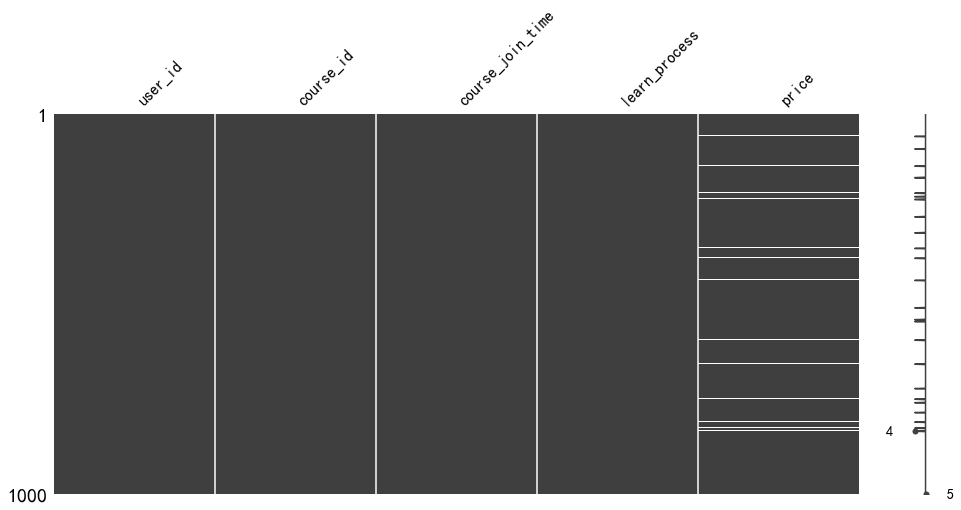

In [9]:
# 查看缺失值分布
import missingno as msno
msno.matrix(df_study_info.sample(1000),
            figsize=(16, 7),
            width_ratios=(15, 1))

# 缺失值柱状图
# msno.bar(df_study_info.sample(10000))

In [10]:
# 查看缺失值特性
df_study_info[df_study_info['price'].isna()]['course_id'].unique()

array(['课程51', '课程96'], dtype=object)

In [11]:
df_study_info[df_study_info['course_id']=='课程96'].price.unique()

array([nan])

In [12]:
avg_price_course = df_study_info.groupby("course_id")["price"].mean()  
print("存在价格缺失的课程均价：",avg_price_course.loc["课程51"])
print("存在价格缺失的课程均价：",avg_price_course.loc["课程96"]) 

# 课程51、课程96属于整体价格缺失，无替代方法，因此采用直接删除的方法处理缺失值
df_study_info.dropna(inplace=True)     

存在价格缺失的课程均价： nan
存在价格缺失的课程均价： nan


#### 异常值处理

In [13]:
for col in df_study_info.columns:
    a = df_study_info[col]
    print(a.value_counts().sort_values()) 

用户26809      1
用户36570      1
用户7960       1
用户19480      1
用户1410       1
          ... 
用户29672     77
用户33203     80
用户24        88
用户4         89
用户18436    103
Name: user_id, Length: 40373, dtype: int64
课程93         1
课程92         1
课程91         1
课程90         1
课程104        2
         ...  
课程180     6223
课程191     7126
课程17      8505
课程31      9521
课程76     13265
Name: course_id, Length: 239, dtype: int64
2018-11-05 19:35:48       1
2018-12-29 10:38:14       1
2020-03-09 10:13:10       1
2020-02-12 13:22:06       1
2019-03-22 15:17:35       1
                       ... 
2020-04-20 11:13:02     786
2020-04-01 09:38:44    1190
2020-04-01 09:38:33    1208
2020-04-01 09:39:24    1210
2020-06-11 14:21:55    2501
Name: course_join_time, Length: 65050, dtype: int64
width: 49%;         30
width: 66%;         43
width: 51%;         44
width: 65%;         48
width: 68%;         51
                 ...  
width: 50%;       2025
width: 7%;        3063
width: 4%;        7206
width: 100%;     

#### 重复值处理

In [14]:
df_study_info.drop_duplicates(inplace=True)

### 用户信息表

#### 数据预览

In [15]:
df_users.head(5)

,user_id,register_time,recently_logged,number_of_classes_join,number_of_classes_out,learn_time,school
0,用户44251,2020/6/18 9:49,2020/6/18 9:49,0,0,41.250,NaN
1,用户44250,2020/6/18 9:47,2020/6/18 9:48,0,0,0.000,NaN
2,用户44249,2020/6/18 9:43,2020/6/18 9:43,0,0,16.220,NaN
3,用户44248,2020/6/18 9:09,2020/6/18 9:09,0,0,0.000,NaN
4,用户44247,2020/6/18 7:41,2020/6/18 8:15,0,0,1.800,NaN


#### 缺失值处理

学校字段存在缺失字段，但school字段为非重要字段，且占比较小因此不做处理

In [16]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43983 entries, 0 to 43982
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 43916 non-null  object 
 1   register_time           43983 non-null  object 
 2   recently_logged         43983 non-null  object 
 3   number_of_classes_join  43983 non-null  int64  
 4   number_of_classes_out   43983 non-null  int64  
 5   learn_time              43983 non-null  float64
 6   school                  10571 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 2.3+ MB


In [129]:
# df_users.school.unique()

#### 异常值处理

recently_logged字段中存在异常值“--”
结合后续分析与该表同其余表格的关联性，将异常分类为：

假异常：为流失用户所产生，因此最近登录时间为“--”

真异常：缺失、错误等

结论：

多数异常数据中-皆独立关联一个用户，仅有用户40732存在两条异常数据
因此认为改异常数据为-假异常，为流失用户产生，暂时不做处理

In [18]:
for col in df_users.columns:
    a  = df_users[col]
    print(a.value_counts().sort_values())

用户270      1
用户33426    1
用户14427    1
用户2529     1
用户8202     1
          ..
用户40732    2
用户7909     2
用户36488    2
用户25993    2
用户38350    3
Name: user_id, Length: 43908, dtype: int64
2019/12/12 8:33       1
2020/4/3 20:38        1
2019/11/11 9:55       1
2019/6/21 9:25        1
2019/11/11 16:41      1
                   ... 
2020/3/3 11:47      142
2020/1/15 17:26     145
2020/3/3 15:21      146
2020/2/19 16:32     198
2020/2/12 20:47     216
Name: register_time, Length: 29939, dtype: int64
2020/5/3 15:47         1
2020/2/25 16:09        1
2020/4/6 20:17         1
2019/11/21 16:16       1
2020/5/2 23:50         1
                    ... 
2020/6/18 8:57         5
2019/10/10 10:15       6
2020/6/18 8:48         6
2020/6/17 21:15        6
--                  5376
Name: recently_logged, Length: 35972, dtype: int64
18        1
14        1
13        1
12        1
11        3
10        5
9        11
8        18
7        45
6       115
5       281
4       473
3       952
2      2287
1     1

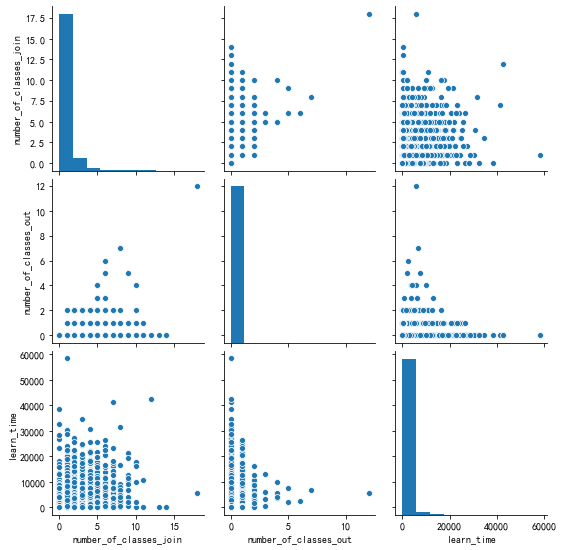

In [19]:
sns.pairplot(df_users)

In [20]:
# 获取异常数据-最近登陆时间
err_data1 = df_users[df_users.recently_logged=="--"]
err_data1

,user_id,register_time,recently_logged,number_of_classes_join,number_of_classes_out,learn_time,school
11,用户44240,2020/6/17 17:25,--,1,0,1667.280,NaN
12,用户44239,2020/6/17 17:24,--,1,0,2109.750,NaN
14,用户44235,2020/6/17 16:39,--,1,0,0.000,NaN
15,用户44237,2020/6/17 16:39,--,1,0,10348.620,NaN
16,用户44232,2020/6/17 16:39,--,1,0,9054.720,NaN
...,...,...,...,...,...,...,...
43772,用户214,2018/10/25 20:46,--,0,0,0.000,NaN
43789,用户197,2018/10/25 19:53,--,0,0,3.100,NaN
43834,用户151,2018/10/25 18:26,--,0,0,0.000,NaN
43868,用户117,2018/10/25 17:47,--,0,0,0.000,NaN


In [21]:
err_data2  = err_data1.groupby('user_id').count().sort_values('register_time',ascending=False)
err_data2

# 多数异常数据中-皆独立关联一个用户，仅有用户40732存在两条异常数据
# 因此认为改异常数据为-假异常，为流失用户产生，暂时不做处理

,register_time,recently_logged,number_of_classes_join,number_of_classes_out,learn_time,school
user_id,,,,,,
用户40732,2,2,2,2,2,0
用户10266,1,1,1,1,1,0
用户43253,1,1,1,1,1,1
用户43252,1,1,1,1,1,1
用户43251,1,1,1,1,1,1
...,...,...,...,...,...,...
用户3855,1,1,1,1,1,0
用户3854,1,1,1,1,1,0
用户38419,1,1,1,1,1,0


#### 重复值处理

In [22]:
df_users.drop_duplicates(inplace=True)

## 用户分布分析

In [23]:
# 分列-分割login_place,获取国家、省份、地区列
login_data = df_login.copy() 

In [24]:
for i in range(login_data.shape[0]):
    if login_data.loc[i,'login_place'][0:2]=='中国':
        login_data.loc[i,'国家']='中国'
        if '黑龙江' in login_data.loc[i,'login_place']:
            login_data.loc[i,'省份']=login_data.loc[i,'login_place'][2:5]
            if len(login_data.loc[i,'login_place'])>5:
                login_data.loc[i,'地区']=login_data.loc[i,'login_place'][5:]
#             else:pass
        if '新疆维吾尔' in login_data.loc[i,'login_place']:
            login_data.loc[i,'省份']=login_data.loc[i,'login_place'][2:7]
            if len(login_data.loc[i,'login_place'])>7:
                login_data.loc[i,'地区']=login_data.loc[i,'login_place'][7:]
#             else:pass
        if '内蒙古' in login_data.loc[i,'login_place']:
            login_data.loc[i,'省份']=login_data.loc[i,'login_place'][2:5]
            if len(login_data.loc[i,'login_place'])>5:
                login_data.loc[i,'地区']=login_data.loc[i,'login_place'][5:]
#             else:pass
        else:
            login_data.loc[i,'省份']=login_data.loc[i,'login_place'][2:4]
            login_data.loc[i,'地区']=login_data.loc[i,'login_place'][4:]   
    else:
        li=[word for word in jieba.cut(login_data.iloc[i,2])]
        if len(li)==2:
            login_data.loc[i,'国家']=li[0]
            login_data.loc[i,'省份']=li[1]
        else:
            login_data.loc[i,'国家']=li[0]
    
    if i%10000==0:
        print(f'{round(i*100/(int(login_data.shape[0])),2)}%')  

0.0%


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\DELL\AppData\Local\Temp\jieba.cache
Loading model cost 0.470 seconds.
Prefix dict has been built successfully.


2.58%
5.17%
7.75%
10.33%
12.92%
15.5%
18.08%
20.66%
23.25%
25.83%
28.41%
31.0%
33.58%
36.16%
38.75%
41.33%
43.91%
46.49%
49.08%
51.66%
54.24%
56.83%
59.41%
61.99%
64.58%
67.16%
69.74%
72.32%
74.91%
77.49%
80.07%
82.66%
85.24%
87.82%
90.41%
92.99%
95.57%
98.15%


### 海内外用户分布

平台主要业务集中在中国地区，用户数占比在99%以上

海外地区业务占比很小很小，相对而言在欧洲地区有零星几位，其中英国用户占比较高

国内用户平均登录次数为10.1次。海外用户平均登录次数相对较低，但该数据样本较少，并无显著的统计学意义，可忽略

In [25]:
# 海内外用户分布表
login_place_data = login_data.drop_duplicates(subset="user_id").loc[:,["user_id","国家"]]
login_place_data = login_place_data.groupby('国家').count()
login_place_data

,user_id
国家,
中国,38300
南非,1
希腊,1
德国,8
捷克,1
波兰,1
泰国,1
瑞典,1
英国,18


In [26]:
# 海内外用户登录分布表 
login_fre_data = pd.DataFrame(login_data.groupby('国家').count()['user_id']).rename(columns={"user_id":"登录总数"})
login_fre_data['用户总数'] = login_place_data.user_id
login_fre_data['平均登录次数'] = login_fre_data["登录总数"]/login_fre_data["用户总数"]
login_fre_data

,登录总数,用户总数,平均登录次数
国家,,,
中国,386914,38300.000,10.102
南非,3,1.000,3.000
希腊,1,1.000,1.000
德国,24,8.000,3.000
挪威,1,nan,nan
捷克,4,1.000,4.000
波兰,7,1.000,7.000
泰国,2,1.000,2.000
瑞典,1,1.000,1.000


In [27]:
login_fre_data.reset_index()

,国家,登录总数,用户总数,平均登录次数
0,中国,386914,38300.000,10.102
1,南非,3,1.000,3.000
2,希腊,1,1.000,1.000
3,德国,24,8.000,3.000
4,挪威,1,nan,nan
5,捷克,4,1.000,4.000
6,波兰,7,1.000,7.000
7,泰国,2,1.000,2.000
8,瑞典,1,1.000,1.000
9,瑞士,1,nan,nan


### 国内用户分布

从地理分布来看，该平台业务覆盖较为全面，全国各省份皆有用户分布，主要服务人群以华中、华南、华东地区用户为主，相对较为偏远的地区：西藏、新疆、内蒙等则分布较少，同时港澳台地区也涉及较少

主要省份为：广东、湖北、北京、江苏、山东、浙江等  
用户量：  
全国各省份的平均用户量为1094，最大用户量为广东省8575，最小用户量为西藏仅14位  
登录量：  
全国各省份的平均登录量为11054.7次，各省份的平均每用户登录量为8.8次  
平均每用户登录量——最高为贵州16.0次，最低为北京2.65次  
北京用户登录表现较差——应深入探索其原因：竞争？宣发？营销？用户不匹配？  
贵州用户登录表现较好——应深入探索其原因：用户特征？市场环境？直接竞争情况？  
重点省份登录量分布:  

广东（总数：120887）  

广州---登录量：27626、占比：22.85%  
汕头---登录量：18509、占比：8.39%  
深圳---登录量：10146、占比7.53%  
数据缺失：27626、占比22.85%  
湖北（总数：33149）：  

武汉---登录量：6534、占比：19.71%  
黄冈---登录量：2935、占比：8.85%  
襄阳---登录量：2359、占比7.12%  
数据缺失：8516、占比25.69%  
贵州（总数：18786）  

贵阳---登录数：3603、占比：19.18%  
遵义---登录数：2388、占比：12.71%  
毕节---登录数：1503、占比：8%  
数据缺失：无  
河南（总数：18550）  
周口---登录数：2508、占比：13.52%  
郑州---登录数：2465、占比：13.29%  
南阳---登录数：1428、占比：7.7%  
数据缺失：1725、占比：9.3%  
山东（总数：14874）  

青岛---登录数：1901、占比：12.78%  
济南---登录数：1827、占比：12.28%  
临沂---登录数：1180、占比：7.93%  
数据缺失：1365、占比：9.18%  
基本规律：越发达的城市（互联网深入程度），用户的登录表现越好。  

进一步探索：针对各省份中登录表现较好地区进行重点调查：问卷调查、用户行为特征等。

In [28]:
# 国内用户登录分布
login_data_cn = login_data[login_data.国家 == "中国"] 
login_data_cn = login_data_cn.groupby("省份").count()[["user_id"]]
# 国内用户数量分布 
login_users_cn_data = login_data.drop_duplicates(subset="user_id")
login_users_cn_data = login_users_cn_data.groupby("省份").count()[["login_place"]] 

# 汇总表 
cn_login_data_all = login_users_cn_data.join(login_data_cn).rename(columns={"login_place":"用户总数","user_id":"登录总数"})
cn_login_data_all['平均登录次数'] = round(cn_login_data_all["登录总数"]/cn_login_data_all["用户总数"],2)
cn_login_data_all = cn_login_data_all.sort_values(by="用户总数",ascending=False) 

cn_login_data_all["登录数百分比"] = round(cn_login_data_all.登录总数*100/cn_login_data_all.登录总数.sum(),2)  
cn_login_data_all["登录数累积百分比"] = round(cn_login_data_all.登录总数.cumsum()*100/cn_login_data_all.登录总数.sum(),2)  

# cn_login_data_all.登录总数.mean() 

cn_login_data_all.reset_index()

,省份,用户总数,登录总数,平均登录次数,登录数百分比,登录数累积百分比
0,广东,8575,120887,14.100,31.240,31.240
1,湖北,2810,33149,11.800,8.570,39.810
2,北京,1869,4946,2.650,1.280,41.090
3,江苏,1780,11237,6.310,2.900,43.990
4,山东,1708,14874,8.710,3.840,47.840
5,浙江,1697,13366,7.880,3.450,51.290
6,河北,1603,14708,9.180,3.800,55.090
7,四川,1594,13099,8.220,3.390,58.480
8,河南,1567,18550,11.840,4.790,63.270
9,上海,1414,5365,3.790,1.390,64.660


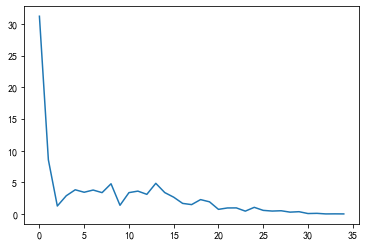

In [29]:
x = range(len(cn_login_data_all["登录数百分比"]))
y = cn_login_data_all["登录数百分比"]
plt.plot(x, y)
plt.show()

In [30]:
# 国内各省份用户数及平均登录分布
bar = (
    Bar(init_opts=opts.InitOpts(bg_color='#d9d6c3'))
    .add_xaxis(list(cn_login_data_all.index))
    .add_yaxis("用户总数", list(cn_login_data_all.用户总数),color="#87843b")
    .extend_axis(
            yaxis=opts.AxisOpts(
                axislabel_opts=opts.LabelOpts(formatter="{value}/次数"), interval=2
            )
        )
    .set_global_opts(
        # 标题位置
        title_opts=opts.TitleOpts(title="国内各省份用户数及平均登录分布"))
    .set_series_opts(
        label_opts=opts.LabelOpts(is_show=False),
        markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(type_="max",name="Max"),
                                                            opts.MarkPointItem(type_="min",name="Min")]),
        markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(type_="average",name="Average")]))
)

line = ( 
    Line()
    .add_xaxis(list(cn_login_data_all.index))
    .add_yaxis("平均登录次数",cn_login_data_all["平均登录次数"], yaxis_index=1)
    .set_series_opts(
            label_opts=opts.LabelOpts(is_show=False),
            markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(type_="max",name="Max"),
                                                            opts.MarkPointItem(type_="min",name="Min")]),
            markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(type_="average",name="Average")])))

bar.overlap(line)
bar.render_notebook() 


In [31]:
map_data = []
for z in zip(cn_login_data_all.index,cn_login_data_all.登录总数):
    map_data.append(z)

In [32]:
map=Map(init_opts=opts.InitOpts(bg_color='#d9d6c3'))
map.add(series_name="登陆量",
        data_pair=map_data,
        maptype="china"
       )
map.set_global_opts(title_opts=opts.TitleOpts("全国各省份登录分布"),
                    visualmap_opts=opts.VisualMapOpts(max_=40000))

map.set_series_opts(label_opts=opts.LabelOpts(is_show=True))

map.render_notebook() 

In [33]:
# 重点省份用户分布情况---取登录量TOP5
top5_place = pd.DataFrame(cn_login_data_all.登录总数.sort_values(ascending=False)[:5]).index

gd_info = login_data[login_data.省份 == "广东"].groupby('地区').count()[["user_id"]].rename(columns={"user_id":"登录量"}).reset_index()  
gd_info.iloc[0,0] = "暂无"
gd_info.sort_values(by="登录量",ascending=False,inplace=True)


hb_info = login_data[login_data.省份 == "湖北"].groupby('地区').count()[["user_id"]].rename(columns={"user_id":"登录量"}).reset_index()  
hb_info.iloc[0,0] = "暂无"
hb_info.sort_values(by="登录量",ascending=False,inplace=True)


gz_info = login_data[login_data.省份 == "贵州"].groupby('地区').count()[["user_id"]].rename(columns={"user_id":"登录量"}).reset_index()  
gz_info.iloc[0,0] = "暂无"
gz_info.sort_values(by="登录量",ascending=False,inplace=True)


hn_info = login_data[login_data.省份 == "河南"].groupby('地区').count()[["user_id"]].rename(columns={"user_id":"登录量"}).reset_index()  
hn_info.iloc[0,0] = "暂无"
hn_info.sort_values(by="登录量",ascending=False,inplace=True)


sd_info = login_data[login_data.省份 == "山东"].groupby('地区').count()[["user_id"]].rename(columns={"user_id":"登录量"}).reset_index()  
sd_info.iloc[0,0] = "暂无"
sd_info.sort_values(by="登录量",ascending=False,inplace=True)

In [34]:
pie =Pie(init_opts=opts.InitOpts(bg_color='#d9d6c3'))
pie.add(   
            "",
            [z for z in zip(gd_info.地区,gd_info.登录量)],
            radius = ["18%","80%"],
            center=['50%','55%'],
#             rosetype="area",
            color='auto')

pie.set_global_opts(
            title_opts = opts.TitleOpts(title="广东各地区登录量分布"),
            legend_opts = opts.LegendOpts(is_show=False,orient="verticmin",pos_top="15%",pos_left="2%")
)

pie.set_series_opts(
            label_opts = opts.LabelOpts(font_size=12,formatter="{b}:{c}\n{d}%")
)

pie.render_notebook() 

In [35]:
pie =Pie(init_opts=opts.InitOpts(bg_color='#d9d6c3'))
pie.add(   
            "",
            [z for z in zip(hb_info.地区,hb_info.登录量)],
            radius = ["38%","80%"],
            center=['65%','55%'],
#             rosetype="area",
            color='auto')

pie.set_global_opts(
            title_opts = opts.TitleOpts(title="湖北各地区登录量分布"),
            legend_opts = opts.LegendOpts(is_show=False,orient="verticmin",pos_top="15%",pos_left="2%")
)

pie.set_series_opts(
            label_opts = opts.LabelOpts(font_size=12,formatter="{b}:{c}\n{d}%")
)

pie.render_notebook() 

In [36]:
pie =Pie(init_opts=opts.InitOpts(bg_color='#d9d6c3'))
pie.add(   
            "",
            [z for z in zip(gz_info.地区,gz_info.登录量)],
            radius = ["38%","80%"],
            center=['65%','55%'],
            rosetype="area",
            color='auto')

pie.set_global_opts(
            title_opts = opts.TitleOpts(title="贵州各地区登录量分布"),
            legend_opts = opts.LegendOpts(orient="verticmin",pos_top="15%",pos_left="2%")
)

pie.set_series_opts(
            label_opts = opts.LabelOpts(font_size=12,formatter="{b}:{c}\n{d}%")
)

pie.render_notebook() 

In [37]:
pie =Pie(init_opts=opts.InitOpts(bg_color='#d9d6c3'))
pie.add(   
            "",
            [z for z in zip(hn_info.地区,hn_info.登录量)],
            radius = ["38%","80%"],
            center=['50%','55%'],
            rosetype="area",
            color='auto')

pie.set_global_opts(
            title_opts = opts.TitleOpts(title="河南各地区登录量分布"),
            legend_opts = opts.LegendOpts(is_show=False,orient="verticmin",pos_top="15%",pos_left="2%")
)

pie.set_series_opts(
            label_opts = opts.LabelOpts(font_size=12,formatter="{b}:{c}\n{d}%")
)

pie.render_notebook() 

In [38]:
pie =Pie()
pie.add(   
            "",
            [z for z in zip(sd_info.地区,sd_info.登录量)],
            radius = ["38%","80%"],
            center=['65%','55%'],
            rosetype="area",
            color='auto')

pie.set_global_opts(
            title_opts = opts.TitleOpts(title="山东各地区登录量分布"),
            legend_opts = opts.LegendOpts(orient="verticmin",pos_top="15%",pos_left="2%")
)

pie.set_series_opts(
            label_opts = opts.LabelOpts(font_size=12,formatter="{b}:{c}\n{d}%")
)

pie.render_notebook() 

## 用户活跃度分析

不同时期用户活跃度差异：

相较于非工作日，工作日各个时段的登录量均远高于非工作日的登录量  
工作日平均登录登录量：9720、非工作日平均登录量：6410  

工作日和非工作日的登陆频次基本一致，均在上午 8：00-11：00， 下午 14：00-17：00，晚上 20：00-21：00 出现三个高峰，波动趋势基本一致。

工作日中上午、下午、夜间的登录表现程一定程度的递减  
非工作日的三个时间段的登陆表现则较为均衡  

In [39]:
# 时间处理
login_data['login_time'] = pd.to_datetime(login_data.login_time) 
login_data["日期"] = pd.to_datetime(login_data.login_time.dt.date)
login_data["日期编码"] = login_data.日期.dt.weekday 
login_data["时间段编码"]=login_data.login_time.dt.hour
login_data["登录时间段"] = login_data.login_time.dt.timetz 

In [40]:
login_data

,user_id,login_time,login_place,国家,省份,地区,日期,日期编码,时间段编码,登录时间段
0,用户3,2018-09-06 09:32:47,中国广东广州,中国,广东,广州,2018-09-06,3,9,09:32:47
1,用户3,2018-09-07 09:28:28,中国广东广州,中国,广东,广州,2018-09-07,4,9,09:28:28
2,用户3,2018-09-07 09:57:44,中国广东广州,中国,广东,广州,2018-09-07,4,9,09:57:44
3,用户3,2018-09-07 10:55:07,中国广东广州,中国,广东,广州,2018-09-07,4,10,10:55:07
4,用户3,2018-09-07 12:28:42,中国广东广州,中国,广东,广州,2018-09-07,4,12,12:28:42
...,...,...,...,...,...,...,...,...,...,...
387139,用户44247,2020-06-18 07:41:22,中国湖北武汉,中国,湖北,武汉,2020-06-18,3,7,07:41:22
387140,用户44247,2020-06-18 08:13:28,中国湖北,中国,湖北,,2020-06-18,3,8,08:13:28
387141,用户44248,2020-06-18 09:09:07,中国天津,中国,天津,,2020-06-18,3,9,09:09:07
387142,用户44249,2020-06-18 09:43:15,中国北京,中国,北京,,2020-06-18,3,9,09:43:15


In [41]:
# 工作日分类
workday_info = []
for i in login_data['日期编码']:
    if i>=0 and i <=4:
        workday_info.append('工作日')
    else:
        workday_info.append('非工作日')
login_data['是否工作日'] = workday_info

In [42]:
## 法定节假日
login_data["是否工作日_调整后"] = login_data.是否工作日
login_data.set_index(keys="日期",inplace=True)

login_data.loc["2018-10-1":"2018-10-7","是否工作日_调整后"] = "非工作日"
login_data.loc["2018-9-29":"2018-9-30","是否工作日_调整后"] = "工作日"

login_data.loc["2018-12-30":"2019-1-1","是否工作日_调整后"] = "非工作日"
login_data.loc["2018-12-29","是否工作日_调整后"] = "工作日"

login_data.loc["2019-2-4":"2019-2-10","是否工作日_调整后"] = "非工作日"
login_data.loc["2019-2-2":"2019-2-3","是否工作日_调整后"] = "工作日"

login_data.loc["2019-4-5","是否工作日_调整后"] = "非工作日" 
login_data.loc["2019-5-1":"2019-5-4","是否工作日_调整后"] = "非工作日" 

login_data.loc["2019-4-28","是否工作日_调整后"] = "工作日" 
login_data.loc["2019-5-5","是否工作日_调整后"] = "工作日" 

login_data.loc["2019-6-7","是否工作日_调整后"] = "非工作日" 
login_data.loc["2019-9-13","是否工作日_调整后"] = "非工作日" 
login_data.loc["2019-10-1":"2019-10-7","是否工作日_调整后"] = "非工作日" 

login_data.loc["2019-9-29","是否工作日_调整后"] = "工作日" 
login_data.loc["2019-10-12","是否工作日_调整后"] = "工作日" 

login_data.loc["2020-1-24":"2020-1-30","是否工作日_调整后"] = "非工作日" 
login_data.loc["2020-4-4":"2020-5-6","是否工作日_调整后"] = "非工作日" 
login_data.loc["2020-5-1":"2020-5-5","是否工作日_调整后"] = "非工作日" 

login_data.loc["2020-1-19","是否工作日_调整后"] = "工作日" 
login_data.loc["2020-2-1","是否工作日_调整后"] = "工作日" 
login_data.loc["2020-4-26","是否工作日_调整后"] = "工作日" 
login_data.loc["2020-5-9","是否工作日_调整后"] = "工作日" 

In [43]:
login_data

,user_id,login_time,login_place,国家,省份,地区,日期编码,时间段编码,登录时间段,是否工作日,是否工作日_调整后
日期,,,,,,,,,,,
2018-09-06,用户3,2018-09-06 09:32:47,中国广东广州,中国,广东,广州,3,9,09:32:47,工作日,工作日
2018-09-07,用户3,2018-09-07 09:28:28,中国广东广州,中国,广东,广州,4,9,09:28:28,工作日,工作日
2018-09-07,用户3,2018-09-07 09:57:44,中国广东广州,中国,广东,广州,4,9,09:57:44,工作日,工作日
2018-09-07,用户3,2018-09-07 10:55:07,中国广东广州,中国,广东,广州,4,10,10:55:07,工作日,工作日
2018-09-07,用户3,2018-09-07 12:28:42,中国广东广州,中国,广东,广州,4,12,12:28:42,工作日,工作日
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-18,用户44247,2020-06-18 07:41:22,中国湖北武汉,中国,湖北,武汉,3,7,07:41:22,工作日,工作日
2020-06-18,用户44247,2020-06-18 08:13:28,中国湖北,中国,湖北,,3,8,08:13:28,工作日,工作日
2020-06-18,用户44248,2020-06-18 09:09:07,中国天津,中国,天津,,3,9,09:09:07,工作日,工作日


In [44]:
ac_info = login_data[login_data['是否工作日_调整后']=='工作日'].groupby('时间段编码').count()['user_id'].reset_index().rename(columns = {'user_id':"工作日活跃度"})
ac_info['非工作日活跃度'] = login_data[login_data['是否工作日_调整后']=='非工作日'].groupby('时间段编码').count()['user_id']
ac_info

,时间段编码,工作日活跃度,非工作日活跃度
0,0,2917,2141
1,1,1128,815
2,2,499,436
3,3,277,221
4,4,177,134
5,5,200,160
6,6,652,431
7,7,2957,1908
8,8,11235,6582
9,9,16891,9734


In [45]:
#初始化
bar = Bar(init_opts=opts.InitOpts(bg_color='#d9d6c3'))
#添加 x 轴数据
bar.add_xaxis([str(i) for i in ac_info.时间段编码])
#添加 y 轴数据
bar.add_yaxis("工作日活跃度",[i for i in ac_info.工作日活跃度],color="#74905d")
bar.add_yaxis("非工作日活跃度",[i for i in ac_info.非工作日活跃度],color="#80752c")



#全局配置设置
bar.set_global_opts(title_opts=opts.TitleOpts(title="用户活跃度分析", subtitle="工作日与非工作日差异"))
bar.set_series_opts(label_opts=opts.LabelOpts(is_show=False),
                    markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(type_="max",name="Max"),
                                                            opts.MarkPointItem(type_="min",name="Min")]),
                    markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(type_="average",name="Average")]))
bar.render_notebook()

## 用户流失率分析

 结合该平台的行为特征，通过样本采集时间与用户最近登录时间（时间差值）将用户划分为以下群体：  
时间差值：  
- 最大值：646天  
- 均值：189天  
- 30天内登录过用户——17%  
- 30天至60天内登录过用户——13%
- 60天至90天内登录过用户——11.5%
- 90天以上登陆过用户——57%
- 600天以上未登录——0.3%

用户类型：  
* 活跃用户：样本采集时间-最近登录时间<60  
 * 数量：13289  
 * 占比：30.5%  
* 潜水用户：60<样本采集时间-最近登录时间<90  
 * 数量：4942  
 * 占比：11.4%  
* 流失用户：样本采集时间-最近登录时间>90  
 * 数量：25282  
 * 占比：58.1%

用户流失率————58.1%

流失用户的时间差值分布：  
* 流失用户的流失天数存在三个峰值，分别在 115 天、242 天和 452 天达到极高值点，分别有 300 名用户、229 名用户和 261 名用户流失，平均该平台每天约有 40 名用户流失，对该网站是去兴趣放弃在该平台上进行学习。

In [46]:
user_data = df_users.copy() 

In [47]:
# 用户表中“最近登陆时间”字段中存在异常值“--”，使用该用户最近加入的课程的加入时间代替，仍有缺失则表示真实异常 

# 连接课程信息表，找到用户的最近加入课程时间 
err_user_data = user_data[user_data.recently_logged =='--']
t = df_study_info.merge(err_user_data,on = 'user_id',how = 'inner')
tt = t.groupby("user_id").agg({"course_join_time":"max"}).reset_index() 
ttt =err_user_data.merge(tt,how="left",on="user_id")

In [48]:
ttt

,user_id,register_time,recently_logged,number_of_classes_join,number_of_classes_out,learn_time,school,course_join_time
0,用户44240,2020/6/17 17:25,--,1,0,1667.280,NaN,2020-06-17 17:26:08
1,用户44239,2020/6/17 17:24,--,1,0,2109.750,NaN,2020-06-17 17:25:57
2,用户44235,2020/6/17 16:39,--,1,0,0.000,NaN,2020-06-17 16:40:57
3,用户44237,2020/6/17 16:39,--,1,0,10348.620,NaN,2020-06-17 16:40:58
4,用户44232,2020/6/17 16:39,--,1,0,9054.720,NaN,2020-06-17 16:40:55
...,...,...,...,...,...,...,...,...
5370,用户214,2018/10/25 20:46,--,0,0,0.000,NaN,2018-10-25 20:47:22
5371,用户197,2018/10/25 19:53,--,0,0,3.100,NaN,2018-10-26 19:10:25
5372,用户151,2018/10/25 18:26,--,0,0,0.000,NaN,NaN
5373,用户117,2018/10/25 17:47,--,0,0,0.000,NaN,NaN


In [49]:
# 替换异常值
for i in user_data.user_id:
    if i in list(ttt.user_id):
        ture_time = ttt[ttt.user_id == i]["course_join_time"].values[0]
        user_data.loc[(user_data.user_id == i),"recently_logged"] = ture_time
    else:pass

In [50]:
user_data.recently_logged = pd.to_datetime(user_data.recently_logged)

user_data["样本采集时间"] = "2020-6-18 00:00:00"
user_data["样本采集时间"] = pd.to_datetime(user_data.样本采集时间)
user_data["时间差值"] = user_data["样本采集时间"]-user_data.recently_logged
user_data.时间差值 = user_data.时间差值.dt.days + 1

In [51]:
# 时间差值描述统计表
pd.DataFrame(user_data.时间差值.describe())   

,时间差值
count,43684.000
mean,189.534
std,170.596
min,0.000
25%,49.000
50%,115.000
75%,340.000
max,646.000


In [52]:
# 各类型用户数
bins = [0,60,90,999]
user_data["用户类型"]=pd.cut(x=user_data.时间差值,bins=bins,labels=["活跃用户","潜在用户","流失用户"])
user_type = user_data.用户类型.value_counts()
print(user_type)

bar = (
        Bar(init_opts=opts.InitOpts(bg_color='#d9d6c3')) 
        .add_xaxis(["流失用户","潜在用户","活跃用户"])
        .add_yaxis("",[25282,4942,13289],color="#726930")
            )
    
bar.render_notebook()

流失用户    25282
活跃用户    13289
潜在用户     4942
Name: 用户类型, dtype: int64


In [53]:
# 用户流失率 
流失率 = round(25282/(4942+13289+25282),4) 

liquid = Liquid(init_opts=opts.InitOpts(bg_color='#d9d6c3'))
liquid.add("流失率",data=[0.58],shape="circle",color="red")
liquid.set_global_opts(title_opts=opts.TitleOpts(title="用户流失率"))


liquid.render_notebook() 

In [54]:
# 各时间差值下的人数
time_fre = user_data.groupby("时间差值").count()[["user_id"]] 

line = ( 
    Line(init_opts=opts.InitOpts(bg_color='#d9d6c3'))
    .add_xaxis(list(time_fre.index))
    .add_yaxis("",time_fre["user_id"],color="#726930")
    .set_series_opts(
            label_opts=opts.LabelOpts(is_show=False),
            markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(type_="max",name="Max"),
                                                            opts.MarkPointItem(type_="min",name="Min")]),
            markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(type_="average",name="Average")])))

line.render_notebook() 

In [55]:
# 流失用户——各时间差值下的人数
time_fre_90 = time_fre.iloc[90:,:]


line = ( 
    Line(init_opts=opts.InitOpts(bg_color='#d9d6c3'))
    .add_xaxis(list(time_fre_90.index.astype(str)))
    .add_yaxis("",time_fre_90["user_id"],is_smooth=True,color="#726930")
    .set_series_opts(
            label_opts=opts.LabelOpts(is_show=True),
            markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(type_="max",name="Max"),
                                                            opts.MarkPointItem(type_="min",name="Min")]),
            markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(type_="average",name="Average")])))

line.render_notebook() 

## 用户流失漏斗模型

In [56]:
study_info_data = df_study_info.copy() 


# 清理学习进度列，获取数值 
study_info_data["learn_process_tru"] = study_info_data.learn_process.apply(lambda x: int(x.split(":")[1].replace("%;",""))/100) 

# 获取每个价位中的平均学习进度 
price_avg_process = study_info_data.groupby("price").agg({"learn_process_tru":"mean"}).reset_index() 
# price_avg_process

# 获取时间字段 
study_info_data["date"] = pd.to_datetime(pd.to_datetime(study_info_data.course_join_time).dt.date) 

In [57]:
study_info_data

,user_id,course_id,course_join_time,learn_process,price,learn_process_tru,date
0,用户3,课程106,2020-04-21 10:11:50,width: 0%;,0.000,0.000,2020-04-21
1,用户3,课程136,2020-03-05 11:44:36,width: 1%;,0.000,0.010,2020-03-05
2,用户3,课程205,2018-09-10 18:17:01,width: 63%;,0.000,0.630,2018-09-10
3,用户4,课程26,2020-03-31 10:52:51,width: 0%;,319.000,0.000,2020-03-31
4,用户4,课程34,2020-03-31 10:52:49,width: 0%;,299.000,0.000,2020-03-31
...,...,...,...,...,...,...,...
194969,用户44245,课程76,2020-06-17 22:16:56,width: 0%;,0.000,0.000,2020-06-17
194970,用户44246,课程76,2020-06-17 22:36:41,width: 4%;,0.000,0.040,2020-06-17
194971,用户44247,课程19,2020-06-18 07:54:07,width: 100%;,499.000,1.000,2020-06-18
194972,用户44247,课程32,2020-06-18 07:41:38,width: 0%;,499.000,0.000,2020-06-18


In [58]:
# 注册用户数  
login_users_counts = df_users.shape[0]

# 加入课程用户数
join_course_users_counts = df_study_info.drop_duplicates(subset="user_id").shape[0] 
# 开始学习用户数 
start_study_users_counts = study_info_data[study_info_data.learn_process_tru>0].drop_duplicates("user_id").shape[0] 
# 结课学习用户数 
end_study_users_counts = study_info_data[study_info_data.learn_process_tru==1].drop_duplicates("user_id").shape[0] 

attr = ["注册","加入课程","开始学习","结课"]
values = [login_users_counts,join_course_users_counts,start_study_users_counts,end_study_users_counts]

attr_data = pd.DataFrame({"环节":attr,"人数":values})
attr_data["总体转化率"] = round(attr_data.人数*100/attr_data.iloc[0,1],2) 
attr_data["环节转化率"] = round(attr_data.人数*100/attr_data.人数.shift(1).fillna(43980),2) 

In [59]:
attr_data

,环节,人数,总体转化率,环节转化率
0,注册,43980,100.000,100.000
1,加入课程,40373,91.800,91.800
2,开始学习,27277,62.020,67.560
3,结课,7675,17.450,28.140


In [60]:
# 总体转接转化率 

funnel = Funnel(init_opts=opts.InitOpts(bg_color='#d9d6c3'))

funnel.add(
    is_selected = True,
    series_name = "总体转化率",
    data_pair = [ z for z in zip(attr_data.环节,attr_data.总体转化率)],
                  )

funnel.set_colors(["#8e7437","#bed742","#726930","#c88400"])

funnel.set_series_opts(
        label_opts = opts.LabelOpts(formatter='{b}:{c}%'),
)

                      
funnel.render_notebook() 

In [61]:
# 单一环节转化率 

funnel = Funnel(init_opts=opts.InitOpts(bg_color='#d9d6c3'))

funnel.add(
    is_selected = True,
    series_name = "总体转化率",
    data_pair = [ z for z in zip(attr_data.环节,attr_data.环节转化率)],
                  )

funnel.set_colors(["#8e7437","#bed742","#726930","#c88400"])

funnel.set_series_opts(
        label_opts = opts.LabelOpts(formatter='{b}:{c}%'),
)

                      
funnel.render_notebook() 

## 用户RMF模型

In [62]:
user_data_r = user_data[["user_id","时间差值"]]
user_data_f = df_study_info.groupby("user_id").count()[["course_id"]].reset_index()    
user_data_m = df_study_info.groupby("user_id").sum().reset_index()   

user_data_rfm = user_data_r.merge(user_data_f,on="user_id",how="right").merge(user_data_m,on="user_id",how="right")

user_data_rfm = user_data_rfm.rename(columns={"时间差值":"R","course_id":"F","price":"M"})

R_score计算  
* R——时间间隔  
* 结合业务划分区间  
 * 用户购买考虑时间3-7天  
  * 课程上新周期2-4周，更新周期4-7周  
  * 课程时长 3-4月  

In [63]:
# user_data_rfm.R.describe()
bins_r = [0,30,60,90,999]
labels_r = [4,3,2,1]  
user_data_rfm["R_score"] = pd.cut(user_data_rfm.R,bins=bins_r,labels=labels_r,include_lowest=True).astype(int)  

F_score计算
* F——消费频率
 * 均值4.7
 * 中位数1
 * 最大值103

In [64]:
# user_data_rfm.F.describe()
bins_f = [0,1.1,3.1,5.1,999]
labels_f = [1,2,3,4]
user_data_rfm["F_score"] = pd.cut(user_data_rfm.F,bins=bins_f,labels=labels_f,include_lowest=True).astype(int)  

M_score计算  
* M——消费金额
 * 均值906
 * 中位数0
 * 最大值22310

In [65]:
# user_data_rfm.M.describe()  
bins_m = [0,1.1,500,1000,9999999]
labels_m = [1,2,3,4]
user_data_rfm["M_score"] = pd.cut(user_data_rfm.M,bins=bins_m,labels=labels_m,include_lowest=True).astype(int) 

In [66]:
R_avg_score = user_data_rfm.R_score.mean() 
F_avg_score = user_data_rfm.F_score.mean() 
M_avg_score = user_data_rfm.M_score.mean() 
R_score_type = []
for i in user_data_rfm.R_score:
    if i > R_avg_score:
        R_score_type.append("高")
    else:
        R_score_type.append("低")
        
        
F_score_type = []
for i in user_data_rfm.F_score:
    if i > F_avg_score:
        F_score_type.append("高")
    else:
        F_score_type.append("低")

        
M_score_type = []
for i in user_data_rfm.M_score:
    if i > M_avg_score:
        M_score_type.append("高")
    else:
        M_score_type.append("低")
        

user_data_rfm["R_score_type"] = R_score_type
user_data_rfm["F_score_type"] = F_score_type
user_data_rfm["M_score_type"] = M_score_type
user_data_rfm["RFM_type"] = user_data_rfm["R_score_type"]+user_data_rfm["F_score_type"]+user_data_rfm["M_score_type"] 

In [67]:
user_data_rfm

,user_id,R,F,M,R_score,F_score,M_score,R_score_type,F_score_type,M_score_type,RFM_type
0,用户44247,0.000,3,998.000,4,2,3,高,高,高,高高高
1,用户44246,1.000,1,0.000,4,1,1,高,低,低,高低低
2,用户44245,1.000,1,0.000,4,1,1,高,低,低,高低低
3,用户44243,1.000,1,0.000,4,1,1,高,低,低,高低低
4,用户44241,1.000,1,0.000,4,1,1,高,低,低,高低低
...,...,...,...,...,...,...,...,...,...,...,...
40373,用户9,8.000,15,1825.000,4,4,4,高,高,高,高高高
40374,用户7,105.000,32,5133.000,1,4,4,低,高,高,低高高
40375,用户5,3.000,72,11518.000,4,4,4,高,高,高,高高高
40376,用户4,13.000,89,13522.000,4,4,4,高,高,高,高高高


In [68]:
users_type = []
for i in range(user_data_rfm.shape[0]):
    if user_data_rfm.loc[i,["RFM_type"]].values == "高高高":
        users_type.append("重要价值客户")
    elif user_data_rfm.loc[i,["RFM_type"]].values == "高低高":
        users_type.append("重要发展客户")
    elif user_data_rfm.loc[i,["RFM_type"]].values == "低高高":
        users_type.append("重要保持客户")
    elif user_data_rfm.loc[i,["RFM_type"]].values == "低低高":
        users_type.append("重要挽留客户")
    elif user_data_rfm.loc[i,["RFM_type"]].values == "高高低":
        users_type.append("一般价值客户")
    elif user_data_rfm.loc[i,["RFM_type"]].values == "高低低":
        users_type.append("一般发展客户")
    elif user_data_rfm.loc[i,["RFM_type"]].values == "低高低":
        users_type.append("一般保持客户")
    else:
        users_type.append("一般挽留客户")
        
        
user_data_rfm["users_type"] = users_type

In [69]:
user_type_info = user_data_rfm.groupby("users_type").count()[["user_id"]] 
type_data = [str(i) for i in user_type_info.index]
type_counts =  [int(i) for i in user_type_info.values]

In [70]:
bar = Bar(init_opts=opts.InitOpts(width=1000,bg_color="#d9d6c3")) 
bar.add_xaxis(type_data)
bar.add_yaxis("",type_counts,color="#726930")



bar.render_notebook() 

In [71]:
17568/user_type_info.sum() 

user_id   0.435
dtype: float64

In [72]:
# 重要客户 
import_user = user_data_rfm[((user_data_rfm.users_type == "重要保持客户")|(user_data_rfm.users_type == "重要发展客户")|(user_data_rfm.users_type == "重要挽留客户")|(user_data_rfm.users_type == "重要价值客户"))][["user_id","users_type"]]
# 客户地址信息 
user_place = login_data.drop_duplicates(subset="user_id")[["user_id","国家","省份","地区"]] 


import_user_info = import_user.merge(user_place,on="user_id",how="inner") 

In [73]:
import_user_sf = import_user_info.groupby("省份").count()[["地区"]].sort_values(by="地区",ascending=False)

In [74]:
bar = Bar(init_opts=opts.InitOpts(width=1000,bg_color="#d9d6c3")) 
bar.add_xaxis([ i for i in import_user_sf.index])
bar.add_yaxis("",[ i for i in import_user_sf.地区],color="#726930")



bar.render_notebook() 

In [75]:
import_user_dq = import_user_info.groupby("地区").count()[["省份"]].sort_values(by="省份",ascending=False)[:10] 

In [76]:
bar = Bar(init_opts=opts.InitOpts(width=1000,bg_color="#d9d6c3")) 
bar.add_xaxis([ i for i in import_user_dq.index])
bar.add_yaxis("",[ i for i in import_user_dq.省份],color="#726930")



bar.render_notebook() 

## 用户课程参与分析

用户课程选择分析  
41.84%的课程参与人数低于100 人  
33.89%的课程参与人数在 100-500 人，即该教育平台上约有 75.73%的课程参与人数低于 500 人，仅有 24.27%的课程参与认出超过 500 人  
课程 76 是选的课程人数最多的课程有 13265 名用户选择该课程  
对比课程76、17、31等热门课程与其他课程的差异  
热门课程类型  
热门课程讲师  
热门课程内容  
...

In [77]:
course_info = study_info_data.groupby("course_id").count()[["user_id"]].reset_index().rename(columns={"user_id":"选择人数"}).sort_values(by="选择人数",ascending=False)

# 通过选择人数，划分课程类型
bins = [0,100,500,1000,5000,10000,999999]
labels = ["选择人数100以下","选择人数100-500","选择人数500-1000","选择人数1000-5000","选择人数5000-10000","选择人数10000以上"]
course_info["选择人数类型"] = pd.cut(x=course_info.选择人数,bins=bins,labels=labels)

In [78]:
course_pie_data = course_info.groupby("选择人数类型").count()   

pie =Pie(init_opts=opts.InitOpts(bg_color='#d9d6c3'))
pie.add(   
            "",
            [ z for z in zip(course_pie_data.index,course_pie_data.选择人数)] ,
            radius = ["38%","80%"],
            center=['50%','50%'],
            rosetype="area",
            )

pie.set_global_opts(
            title_opts = opts.TitleOpts(title=""),
            legend_opts = opts.LegendOpts(is_show=False,orient="verticmin",pos_top="15%",pos_left="2%")
)

pie.set_series_opts(
            label_opts = opts.LabelOpts(font_size=12,formatter="{b}:\n人数：{c}\n占比：{d}%")
)

pie.render_notebook() 

### 课程受欢迎程度

In [79]:
max_x = max(course_info.选择人数)   
min_x = min(course_info.选择人数)

course_info["受欢迎程度"] = course_info["选择人数"].apply(lambda x: (x-min_x)/(max_x-min_x)).sort_values(ascending=False)*100   

In [80]:
course_top10 = course_info[:10] 

bar = (
        Bar(init_opts=opts.InitOpts(bg_color='#d9d6c3')) # 这里可以选择主题
        .add_xaxis(list(course_top10.course_id.values)) 
        .add_yaxis("",[ i for i in course_top10.选择人数],color="#726930")
        .extend_axis(
            yaxis=opts.AxisOpts(
                axislabel_opts=opts.LabelOpts(formatter="{value}"), interval=10
            )
        )
        .set_series_opts(label_opts=opts.LabelOpts(is_show=False,))
        .set_global_opts(
            title_opts=opts.TitleOpts(title=""),
            yaxis_opts=opts.AxisOpts(
                axislabel_opts=opts.LabelOpts(formatter="{value}")
            ),
        )
)
line = Line()
line.add_xaxis(list(course_top10.course_id.values))
line.add_yaxis("",course_top10.受欢迎程度.values, yaxis_index=1,color="#5c7a29")
line.set_series_opts(label_opts=opts.LabelOpts(is_show=False))

bar.overlap(line)
bar.render_notebook()

### 课程分级

In [81]:
# 数据准备

study_info_data["date"] = pd.to_datetime(study_info_data.course_join_time).dt.date
study_info_data["date"] = pd.to_datetime(study_info_data.date) 

course_data_rfm = study_info_data.groupby("course_id").agg({"date":"max","user_id":"count","price":"sum"}).reset_index()  
course_data_rfm["date"] = pd.to_datetime("2020-6-18")-course_data_rfm.date 
course_data_rfm["date"] = course_data_rfm.date.dt.days 

course_data_rfm.rename(columns={"date":"R","user_id":"F","price":"M"},inplace=True) 

缺少课程详细信息，在此只能做大致的课程分级  
免费课程、收费课程就不好放在同一个维度分析，在此默认全部课程都为付费课程

In [82]:
# course_data_rfm.R.describe()
bins_r = [0,20,50,100,999]
labels_r = [4,3,2,1]  
course_data_rfm["R_score"] = pd.cut(course_data_rfm.R,bins=bins_r,labels=labels_r,include_lowest=True).astype(int)  

In [83]:
# course_data_rfm.F.describe()
bins_r = [0,20,150,500,999999]
labels_r = [1,2,3,4]  
course_data_rfm["F_score"] = pd.cut(course_data_rfm.F,bins=bins_r,labels=labels_r,include_lowest=True).astype(int)  

In [84]:
# course_data_rfm.M.describe()
bins_r = [0,1,500,150000,9999999]
labels_r = [1,2,3,4]  
course_data_rfm["M_score"] = pd.cut(course_data_rfm.M,bins=bins_r,labels=labels_r,include_lowest=True).astype(int)  

In [85]:
R_avg_score = course_data_rfm.R_score.mean() 
F_avg_score = course_data_rfm.F_score.mean() 
M_avg_score = course_data_rfm.M_score.mean() 
R_score_type = []
for i in course_data_rfm.R_score:
    if i > R_avg_score:
        R_score_type.append("高")
    else:
        R_score_type.append("低")
        
        
F_score_type = []
for i in course_data_rfm.F_score:
    if i > F_avg_score:
        F_score_type.append("高")
    else:
        F_score_type.append("低")

        
M_score_type = []
for i in course_data_rfm.M_score:
    if i > M_avg_score:
        M_score_type.append("高")
    else:
        M_score_type.append("低")

course_data_rfm["R_score_type"] = R_score_type
course_data_rfm["F_score_type"] = F_score_type
course_data_rfm["M_score_type"] = M_score_type
course_data_rfm["RFM_type"] = course_data_rfm["R_score_type"]+course_data_rfm["F_score_type"]+course_data_rfm["M_score_type"] 

In [86]:
course_type = []
for i in range(course_data_rfm.shape[0]):
    if course_data_rfm.loc[i,["RFM_type"]].values == "高高高":
        course_type.append("核心价值课程")
    elif course_data_rfm.loc[i,["RFM_type"]].values == "高低高":
        course_type.append("重要推广课程")
    elif course_data_rfm.loc[i,["RFM_type"]].values == "低高高":
        course_type.append("重要保持课程")
    elif course_data_rfm.loc[i,["RFM_type"]].values == "低低高":
        course_type.append("重要维护课程")
    elif course_data_rfm.loc[i,["RFM_type"]].values == "高高低":
        course_type.append("一般价值课程")
    elif course_data_rfm.loc[i,["RFM_type"]].values == "高低低":
        course_type.append("一般推广课程")
    elif course_data_rfm.loc[i,["RFM_type"]].values == "低高低":
        course_type.append("折扣处理课程")
    else:
        course_type.append("下架课程")
        
        
course_data_rfm["course_type"] = course_type
course_type_info = course_data_rfm.groupby("course_type").count()[["course_id"]]

In [87]:
pie =Pie(init_opts=opts.InitOpts(bg_color='#d9d6c3'))
pie.add(   
            "",
            [z for z in zip(course_type_info.index,course_type_info.course_id )] ,
            radius = ["18%","80%"],
            center=['50%','55%'],
            rosetype="area",
            color='auto')

pie.set_global_opts(
            title_opts = opts.TitleOpts(title=""),
            legend_opts = opts.LegendOpts(is_show=False,orient="verticmin",pos_top="15%",pos_left="2%")
)

pie.set_series_opts(
            label_opts = opts.LabelOpts(font_size=12,formatter="{b}:{c}\n{d}%")
)

pie.render_notebook() 

### 课程结课率

In [88]:
course_process_1 =  study_info_data.groupby("course_id").count()[["price"]].reset_index() 
course_process_2 = study_info_data[study_info_data.learn_process_tru == 1].groupby("course_id").count()[["user_id"]].reset_index()    
course_process_3 = course_process_1.merge(course_process_2,on="course_id",how="left").fillna(0) 

course_process_3["结课率"] = round(course_process_3.user_id*100/course_process_3.price,2) 
course_process_3.rename(columns={"price":"课程数","user_id":"完课数"},inplace=True)
course_process_3.sort_values(by="结课率",ascending=False,inplace=True) 


bins_pro = [0,0.01,25,50,75,100]
labels_pro = ["结课率0","结课率0-25","结课率25-50","结课率50-75","结课率75-100"]
course_process_3["结课率分布"] = pd.cut(course_process_3.结课率,bins=bins_pro,labels=labels_pro,include_lowest=True)
course_process_info = pd.DataFrame(course_process_3.结课率分布.value_counts())  

In [89]:
# 结课率TOP10 
course_process_top10 = course_process_3[:10] 
course_process_top10[["course_id","结课率"]]

,course_id,结课率
228,课程89,93.750
217,课程79,89.290
90,课程18,81.400
146,课程23,81.400
170,课程35,79.070
114,课程200,75.860
120,课程206,74.420
206,课程69,71.430
111,课程199,71.260
57,课程15,70.370


In [90]:
 [ i for i in course_process_top10.结课率] 

[93.75, 89.29, 81.4, 81.4, 79.07, 75.86, 74.42, 71.43, 71.26, 70.37]

In [91]:
bar = Bar(init_opts=opts.InitOpts(width=1000,bg_color="#d9d6c3")) 
bar.add_xaxis([i for i in course_process_top10.course_id])
bar.add_yaxis("",[ i for i in course_process_top10.结课率],color="#726930")



bar.render_notebook() 

In [92]:
course_process_info 

,结课率分布
结课率0-25,123
结课率0,78
结课率25-50,19
结课率50-75,13
结课率75-100,6


In [93]:
pie =Pie(init_opts=opts.InitOpts(bg_color='#d9d6c3'))
pie.add(   
            "",
            [z for z in zip(course_process_info.index,course_process_info.结课率分布)] ,
            radius = ["18%","80%"],
            center=['50%','55%'],
            rosetype="area",
            color='auto')

pie.set_global_opts(
            title_opts = opts.TitleOpts(title=""),
            legend_opts = opts.LegendOpts(is_show=False,orient="verticmin",pos_top="15%",pos_left="2%")
)

pie.set_series_opts(
            label_opts = opts.LabelOpts(font_size=12,formatter="{b}\n数量：{c}\n占比：{d}%")
)

pie.render_notebook() 

### 课程收入分析

In [94]:
# 总销售额
price_sum = df_study_info.price.sum()

# 用户总数
login_users_counts

# 付费用户数
pay_users_counts =  len(set(df_study_info[df_study_info.price>0]["user_id"]))  

# 总ARPU 
ARPU = round(price_sum/login_users_counts)

# 总ARPPU
ARPPU = round(price_sum/pay_users_counts,2) 

In [95]:
study_info_data["year_month"] = study_info_data.date.dt.year.astype(str)+"年"+study_info_data.date.dt.month.astype(str)+"月"

arpu_info = study_info_data.groupby("year_month").agg({"price":"sum"}).reset_index()  

arpu_info["注册用户数"] = study_info_data.drop_duplicates(subset="user_id").groupby("year_month").count()[["user_id"]].values   

arpu_info["付费用户数"]  = study_info_data[study_info_data.price>0].drop_duplicates("user_id").groupby("year_month").count()[["user_id"]].values

arpu_info["ARPU"] = round(arpu_info.price/arpu_info.注册用户数,2) 
arpu_info["ARPPU"] = round(arpu_info.price/arpu_info.付费用户数,2)

arpu_info["k"] = [2,3,4,1,14,15,16,5,6,7,8,9,10,11,12,13,17,18,19,20,21,22]
arpu_info = arpu_info.sort_values(by="k")

In [96]:
arpu_info 

,year_month,price,注册用户数,付费用户数,ARPU,ARPPU,k
3,2018年9月,4920.000,5,6,984.000,820.000,1
0,2018年10月,2448.000,330,2,7.420,1224.000,2
1,2018年11月,5131.000,413,1,12.420,5131.000,3
2,2018年12月,30059.000,148,28,203.100,1073.540,4
7,2019年1月,17285.000,952,12,18.160,1440.420,5
8,2019年2月,9897.000,689,25,14.360,395.880,6
9,2019年3月,6827.000,2775,46,2.460,148.410,7
10,2019年4月,80586.000,2764,37,29.160,2178.000,8
11,2019年5月,182865.000,1100,135,166.240,1354.560,9
12,2019年6月,183921.000,1057,98,174.000,1876.740,10


In [97]:
# 月总收入 

bar = Bar(init_opts=opts.InitOpts(width=1000,bg_color="#d9d6c3")) 
bar.add_xaxis([i for i in arpu_info.year_month] )
bar.add_yaxis("销售额",[i for i in arpu_info.price],color="#726930")

bar.set_series_opts(
    label_opts=opts.LabelOpts(is_show=False),
    markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(type_="max",name="Max"),
                                                            opts.MarkPointItem(type_="min",name="Min")]),
                    markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(type_="average",name="Average")])               
                   
                   )

bar.render_notebook() 

In [98]:
# 注册用户与付费用户数

bar = Bar(init_opts=opts.InitOpts(width=1000,bg_color="#d9d6c3")) 
bar.add_xaxis([i for i in arpu_info.year_month])
bar.add_yaxis("注册用户",[i for i in arpu_info.注册用户数],color="#726930")
bar.add_yaxis("付费用户",[i for i in arpu_info.付费用户数],color="#c88400")

bar.set_series_opts(
    label_opts=opts.LabelOpts(is_show=False),
    markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(type_="max",name="Max"),
                                                            opts.MarkPointItem(type_="min",name="Min")]),
                    markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(type_="average",name="Average")])               
                   )


bar.render_notebook() 

In [99]:
# 月ARPU、月ARPPU

line=Line(init_opts=opts.InitOpts(width=1000,bg_color="#d9d6c3"))
line.add_xaxis([i for i in arpu_info.year_month])
line.add_yaxis(series_name="ARPU",y_axis=[i for i in arpu_info.ARPU],areastyle_opts=opts.AreaStyleOpts(opacity=0.5))
line.add_yaxis(series_name="ARPPU",y_axis=[i for i in arpu_info.ARPPU],areastyle_opts=opts.AreaStyleOpts(opacity=0.5))

line.set_colors(["#726930","#c88400"])

line.set_global_opts(
                    title_opts=opts.TitleOpts(title=""),)

line.set_series_opts(
                    label_opts=opts.LabelOpts(is_show=False),
                    markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(type_="max",name="Max"),
                                                            opts.MarkPointItem(type_="min",name="Min")]),
                    markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(type_="average",name="Average")]))


line.render_notebook()

## 课程收费差异与学习进度相关性分析

### 课程价格与学习进度关系
* 通过折线图发现——随着课程价格的上升，平均学习时长呈现出波动上市的趋势。  
* 价格越贵，用户投入成本更大，在一定程度上重视程度也更高，因此不能证明学习进度与价格之间一定存在某种正向的关系

In [100]:
study_info_data

,user_id,course_id,course_join_time,learn_process,price,learn_process_tru,date,year_month
0,用户3,课程106,2020-04-21 10:11:50,width: 0%;,0.000,0.000,2020-04-21,2020年4月
1,用户3,课程136,2020-03-05 11:44:36,width: 1%;,0.000,0.010,2020-03-05,2020年3月
2,用户3,课程205,2018-09-10 18:17:01,width: 63%;,0.000,0.630,2018-09-10,2018年9月
3,用户4,课程26,2020-03-31 10:52:51,width: 0%;,319.000,0.000,2020-03-31,2020年3月
4,用户4,课程34,2020-03-31 10:52:49,width: 0%;,299.000,0.000,2020-03-31,2020年3月
...,...,...,...,...,...,...,...,...
194969,用户44245,课程76,2020-06-17 22:16:56,width: 0%;,0.000,0.000,2020-06-17,2020年6月
194970,用户44246,课程76,2020-06-17 22:36:41,width: 4%;,0.000,0.040,2020-06-17,2020年6月
194971,用户44247,课程19,2020-06-18 07:54:07,width: 100%;,499.000,1.000,2020-06-18,2020年6月
194972,用户44247,课程32,2020-06-18 07:41:38,width: 0%;,499.000,0.000,2020-06-18,2020年6月


In [101]:
line = ( 
    Line(init_opts=opts.InitOpts(bg_color='#d9d6c3'))
    .add_xaxis([ str(i) for i in price_avg_process.price])
    .add_yaxis("",[ round(i,2) for i in price_avg_process.learn_process_tru],color="#5c7a29")
    .set_series_opts(
            label_opts=opts.LabelOpts(is_show=False),
            markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(type_="max",name="Max"),
                                                            opts.MarkPointItem(type_="min",name="Min")]),
            markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(type_="average",name="Average")]))
)

line.render_notebook() 

## 课程价格与平均学习进度相关性
* 课程价格与平均学习进度间——弱相关

In [102]:
price_avg_process.corr() 

,price,learn_process_tru
price,1.000,0.062
learn_process_tru,0.062,1.000


## 用户课程推荐策略

课程推荐情况  
协同过滤算法概述  
基于物品的协同过滤算法：  
为用户推荐那些和他们之前喜欢的物品相似的物品。在计算邻居时采用物品本身，基于用户对物品的偏好找到相似的物品，然后根据用户的历史偏好，推荐相似的物品给用户  
从计算的角度看，就是将所有用户对某个物品的偏好作为一个向量来计算物品之间的相似度，得到物品的相似物品后，根据用户历史的偏好预测当前用户还没有表示偏好的物品，计算得到一个排序的物品列表作为推荐。  
例如：  
对于物品 A，根据所有用户的历史偏好，喜欢物品 A 的用户都喜欢物品 C，得出物品 A 和物品 C 比较相似，而用户 C 喜欢物品 A，那么可以推断出用户 C 可能也喜欢物品 C。

* 任务 1 数据预处理

 * 任务 1.1 对照附录 1，理解各字段的含义，进行缺失值、重复值等方面的必12要处理，将处理结果保存为“task1_1_X.csv”（如果包含多张数据表，X 可从 1 开始往后编号），并在报告中描述处理过程。  
 * 任务 1.2 对用户信息表中 recently_logged 字段的“--”值进行必要的处理，将处理结果保存为“task1_2.csv”，并在报告中描述处理过程。 

- 任务 2 平台用户活跃度分析  

 - 任务 2.1 分别绘制各省份与各城市平台登录次数热力地图，并分析用户分布情况。  
 - 任务 2.2 分别绘制工作日与非工作日各时段的用户登录次数柱状图，并分析用户活跃的主要时间段。  
 - 任务 2.3 记𝑇𝑇𝑒𝑒𝑒𝑒𝑒𝑒为数据观察窗口截止时间（如：赛题数据的采集截止时间为2020 年 6 月 18 日），𝑇𝑇𝑖𝑖为用户 i 的最近访问时间，𝜎𝜎𝑖𝑖 = 𝑇𝑇𝑒𝑒𝑒𝑒𝑒𝑒 − 𝑇𝑇𝑖𝑖，若𝜎𝜎𝑖𝑖 > 90天，则称用户 i 为流失用户。根据该定义计算平台用户的流失率。  
 - 任务 2.4 根据任务 2.1 至任务 2.3，分析平台用户的活跃度，为该教育平台的线上管理决策提供建议。

- 任务 3 线上课程推荐  

 - 任务 3.1 根据用户参与学习的记录，统计每门课程的参与人数，计算每门课程的受欢迎程度，列出最受欢迎的前 10 门课程，并绘制相应的柱状图。受欢迎程度定义如下：𝛾𝛾𝑖𝑖 = 𝑄𝑄𝑖𝑖 − 𝑄𝑄min𝑄𝑄max− 𝑄𝑄min。其中，𝛾𝛾𝑖𝑖为第 i 门课程的受欢迎程度，𝑄𝑄𝑖𝑖为参与第 i 门课程学习的人数，𝑄𝑄max和𝑄𝑄min分别为所有课程中参与人数最多和最少的课程所对应的人数。  
 - 任务 3.2 根据用户选择课程情况，构建用户和课程的关系表（二元矩阵），使用基于物品的协同过滤算法计算课程之间的相似度，并结合用户已选课程的记录，为总学习进度最高的 5 名用户推荐 3 门课程。  
 - 任务 3.3 在任务 3.1 和任务 3.2 的基础上，结合用户学习进度数据，分析付费课程和免费课程的差异，给出线上课程的综合推荐策略。

In [103]:
#task1.2
#指定列填充,recently_logged空值时显示为--
#若最近上线时间为空，则以注册日期为最近上线日期
users = df_users.copy()
users['recently_logged']=users['recently_logged'].replace('--',np.NaN)
# users['learn_time']=users['learn_time'].apply(lambda x:re.sub(r'[^\d^\.]+','',x)).astype('float')#去掉数字中的逗号
col=['register_time','recently_logged']
users[col]=users[col].fillna(method='ffill',axis=1)
users['register_time']=pd.to_datetime(users['register_time'],errors='coerce')
users['recently_logged']=pd.to_datetime(users['recently_logged'],errors='coerce')
users.dropna(subset=['recently_logged','register_time'],inplace=True)
users.head()

,user_id,register_time,recently_logged,number_of_classes_join,number_of_classes_out,learn_time,school
0,用户44251,2020-06-18 09:49:00,2020-06-18 09:49:00,0,0,41.250,NaN
1,用户44250,2020-06-18 09:47:00,2020-06-18 09:48:00,0,0,0.000,NaN
2,用户44249,2020-06-18 09:43:00,2020-06-18 09:43:00,0,0,16.220,NaN
3,用户44248,2020-06-18 09:09:00,2020-06-18 09:09:00,0,0,0.000,NaN
4,用户44247,2020-06-18 07:41:00,2020-06-18 08:15:00,0,0,1.800,NaN


In [104]:
login_data

,user_id,login_time,login_place,国家,省份,地区,日期编码,时间段编码,登录时间段,是否工作日,是否工作日_调整后
日期,,,,,,,,,,,
2018-09-06,用户3,2018-09-06 09:32:47,中国广东广州,中国,广东,广州,3,9,09:32:47,工作日,工作日
2018-09-07,用户3,2018-09-07 09:28:28,中国广东广州,中国,广东,广州,4,9,09:28:28,工作日,工作日
2018-09-07,用户3,2018-09-07 09:57:44,中国广东广州,中国,广东,广州,4,9,09:57:44,工作日,工作日
2018-09-07,用户3,2018-09-07 10:55:07,中国广东广州,中国,广东,广州,4,10,10:55:07,工作日,工作日
2018-09-07,用户3,2018-09-07 12:28:42,中国广东广州,中国,广东,广州,4,12,12:28:42,工作日,工作日
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-18,用户44247,2020-06-18 07:41:22,中国湖北武汉,中国,湖北,武汉,3,7,07:41:22,工作日,工作日
2020-06-18,用户44247,2020-06-18 08:13:28,中国湖北,中国,湖北,,3,8,08:13:28,工作日,工作日
2020-06-18,用户44248,2020-06-18 09:09:07,中国天津,中国,天津,,3,9,09:09:07,工作日,工作日


In [105]:
#task2.1 分别绘制各省份与各城市平台登录次数热力地图，并分析用户分布情况。
# #pyecharts画地图时，数据格式类似北京，浙江，不能够有省或者自治区
# login=pd.read_csv('E:/和鲸数据/教育平台线上课程智能推荐/login.csv',encoding='gbk')

# #取出省份
# list_pro=[]
# with open('E:/和鲸数据/教育平台线上课程智能推荐/province.txt', "r",encoding='utf-8') as f:
#     for line in f.readlines():
#         line = line.strip('\n')  #去掉列表中每一个元素的换行符
#         list_pro.append(line)
# login['pro']=login['login_place'].apply(lambda x:''.join(p for p in jieba.lcut(x) if p in list_pro))
login=login_data.copy()
login['pro']=login_data['省份']
login['login_time']=pd.to_datetime(login['login_time'])
login['date']=login['login_time'].dt.date

In [106]:
#task2.1画省份热力图
#由于时间跨度比较长，本文着重研究2020年疫情之后各省份登录热力图
group_pro_date=login.groupby(['date','pro'])
df_login_number=pd.DataFrame(group_pro_date['user_id'].count()).reset_index()#各省每日登录数
list_date=list(df_login_number['date'].unique())
t2=Timeline()
t2.add_schema(is_auto_play = False,play_interval = 500,is_loop_play = False)
for date1 in list_date[500:]:
    df_login_number_temp=df_login_number[df_login_number['date']==date1]
    map1=Map(init_opts=opts.InitOpts(theme='chalk'))
    map1.add('每日登录数',
            [list(z) for z in zip(df_login_number_temp['pro'].tolist(),df_login_number_temp['user_id'].tolist())],
             'china',
            label_opts=opts.LabelOpts(is_show=True),
            is_roam=False)
    map1.set_global_opts(title_opts=opts.TitleOpts(title='{}全国各省用户登录数'.format(date1)),
                        tooltip_opts=opts.TooltipOpts(trigger='item',axis_pointer_type='cross'),
                         visualmap_opts=opts.VisualMapOpts(max_=200)
                        )
    t2.add(map1,"{}".format(date1))
t2.render_notebook()

In [107]:
#task2.1着重考虑2020年之后每周的登录热力图
login.head()
login_heatmap_2020=login[login['login_time'].dt.year==2020]
login_heatmap_2020['weekofyear']=login_heatmap_2020['login_time'].dt.weekofyear
login_heatmap_2020['weekday']=login_heatmap_2020['login_time'].dt.weekday+1
login_heatmap_2020['weekday']=login_heatmap_2020['weekday'].map({1:'星期一',2:'星期二',3:'星期三',4:'星期四',5:'星期五',6:'星期六',7:'星期日'})

group_weekofyear_weekday=login_heatmap_2020.groupby(['weekofyear','weekday'])
df_week_count=(group_weekofyear_weekday['user_id'].count()).reset_index()
list_weekofyear=np.arange(1,26)
list_weekday=['星期一','星期二','星期三','星期四','星期五','星期六','星期日']
heatmap=HeatMap()
heatmap.add_xaxis(list_weekofyear)
heatmap.add_yaxis('每日登录数量',
                 list_weekday,
                 df_week_count.values.tolist(),
                  label_opts=opts.LabelOpts(formatter='{value}周',is_show=False)
                 )
heatmap.set_global_opts(title_opts=opts.TitleOpts(title='2020年每周的登录热力图'),
                       xaxis_opts=opts.AxisOpts(name='周数',
                                               type_='category',
                                               splitline_opts=opts.SplitLineOpts(is_show=True,
                                                                                linestyle_opts=opts.LineStyleOpts(color='grey')
                                                                                ),
                                                axislabel_opts=opts.LabelOpts(formatter='第{value}周',rotate=45,interval=0),
                                                
                                               ),
                       yaxis_opts=opts.AxisOpts(name='星期',
                                                type_='category',
                                               splitline_opts=opts.SplitLineOpts(is_show=True,
                                                                                linestyle_opts=opts.LineStyleOpts(color='grey')),
                                               axislabel_opts=opts.LabelOpts(formatter={'1':'星期一',}),
                                                axistick_opts=opts.AxisTickOpts(is_show=True),

                                               ),
                        visualmap_opts=opts.VisualMapOpts(max_=df_week_count['user_id'].max(), pos_right='0%',pos_top='50%'),
                        tooltip_opts=opts.TooltipOpts(trigger='item'),
                        legend_opts=opts.LegendOpts(is_show=False)
                       )
heatmap.render_notebook()

In [108]:
#task2.1各省份用户注册数
login_user_bar=login.drop_duplicates(subset=['user_id'], keep='first',inplace=False).reset_index(drop=True)
login_user_bar.head()
group_pro=login_user_bar.groupby('pro')
series_pro=group_pro['user_id'].count().sort_values(ascending=False)
series_pro.drop(index='',inplace=True)
def draw_bar(ser):
    bar=Bar(init_opts=opts.InitOpts(theme='chalk'))
    bar.add_xaxis(ser.index.tolist())
    bar.add_yaxis('用户注册数',
                 ser.tolist(),
                 label_opts=opts.LabelOpts(font_size=10),
                 )
    bar.set_global_opts(title_opts=opts.TitleOpts(title='各省市注册用户数的柱状图'),
                       xaxis_opts=opts.AxisOpts(name='省份',
                                               type_='category',
                                               axislabel_opts=opts.LabelOpts(rotate=45,
                                                                             interval=0,
                                                                            is_show=True)
                                               ),
                        yaxis_opts=opts.AxisOpts(name='注册用户数量',
                                                 type_='value',
                                                 splitline_opts=opts.SplitLineOpts(is_show=True,
                                                                                  linestyle_opts=opts.LineStyleOpts(color='grey'),
                                                                                  ),
                                                 axistick_opts=opts.AxisTickOpts(is_show=True)
                                                ),
                        tooltip_opts=opts.TooltipOpts(trigger='axis',axis_pointer_type='cross'),
                        legend_opts=opts.LegendOpts(is_show=False)
                       )
    return bar
draw_bar(series_pro).render_notebook()

In [109]:
#task2.2分别绘制工作日与非工作日各时段的用户登录次数柱状图，并分析用户活跃的主要时间段。
users['date']=users['recently_logged'].dt.date
users['year']=users['recently_logged'].dt.year
users['hour']=users['recently_logged'].dt.hour
users['is_holiday']=users['date'].map(lambda x:chinese_calendar.is_holiday(datetime.datetime.strptime(str(x),'%Y-%m-%d')))
df_group_holiday=users.groupby(['hour','is_holiday'])['user_id'].count().reset_index(name='count')
def draw_bar_two(df):
    bar=Bar(init_opts=opts.InitOpts(theme='chalk'))
    bar.add_xaxis(df_group_holiday['hour'].unique().tolist())
    bar.add_yaxis('工作日用户登录次数',
                 df[df['is_holiday']==False]['count'].tolist(),
                 label_opts=opts.LabelOpts(font_size=10),
                 )
    bar.add_yaxis('非工作日用户登录次数',
                 df[df['is_holiday']==True]['count'].tolist(),
                 label_opts=opts.LabelOpts(font_size=10),
                 )    
    bar.set_global_opts(title_opts=opts.TitleOpts(title='工作日与非工作日各时段的用户登录次数柱状图'),
                       xaxis_opts=opts.AxisOpts(name='时点',
                                               type_='category',
                                               axislabel_opts=opts.LabelOpts(rotate=45,
                                                                             interval=0,
                                                                            is_show=True,
                                                                            formatter='{value}时')
                                            
                                               ),
                        yaxis_opts=opts.AxisOpts(name='用户登录数',
                                                 type_='value',
                                                 splitline_opts=opts.SplitLineOpts(is_show=True,
                                                                                  linestyle_opts=opts.LineStyleOpts(color='grey'),
                                                                                  ),
                                                 axistick_opts=opts.AxisTickOpts(is_show=True)
                                                ),
                        tooltip_opts=opts.TooltipOpts(trigger='axis',axis_pointer_type='cross'),
                        legend_opts=opts.LegendOpts(pos_right='10%')
                       )
    return bar

#去掉疫情期间的数据
users['month']=users['recently_logged'].dt.month
df_group_holiday_nocovid=users[~(users['month']==2) |(users['month']==3)&(users['year']==2020)] \
                            .groupby(['hour','is_holiday'])['user_id'].count().reset_index(name='count')

page=Page()
page.add(draw_bar_two(df_group_holiday))
page.render_notebook()

In [110]:
#task2.3 记𝑇𝑇𝑒𝑒𝑒𝑒𝑒𝑒为数据观察窗口截止时间（如：赛题数据的采集截止时间为2020 年 6 月 18 日），
#𝑇𝑇𝑖𝑖为用户 i 的最近访问时间，𝜎𝜎𝑖𝑖 = 𝑇𝑇𝑒𝑒𝑒𝑒𝑒𝑒 − 𝑇𝑇𝑖𝑖，若𝜎𝜎𝑖𝑖 > 90天，则称用户 i 为流失用户。根据该定义计算平台用户的流失率
users_task23=users.drop(columns=['number_of_classes_join','number_of_classes_out','learn_time','school'])
users_task23['register_date']=users_task23['register_time'].dt.date
users_task23['logged_date']=users_task23['recently_logged'].dt.date
df_task23=pd.DataFrame(pd.date_range('2018-09-03','2020-06-18'),columns=['date'])
df_task23['register_number_everyday']=df_task23['date'].apply(lambda x:len(users_task23[users_task23['register_date']==x]))
df_task23['register_number_total']=0
for index in df_task23.index:
    df_task23['register_number_total'].loc[index]=df_task23['register_number_everyday'].loc[:index].sum()
def calcu_lost_number(date):
    users_task23['temp']=date
    users_task23['temp']=pd.to_datetime(users_task23['temp']).dt.date
    users_task23['delta_day']=users_task23['temp']-users_task23['logged_date']
    return len(users_task23[users_task23['delta_day'].dt.days>90])
df_task23['lost_number_total']=df_task23['date'].apply(lambda x:calcu_lost_number(x))
df_task23['lost_number_everyday']=df_task23['lost_number_total'].diff(1).fillna(0)
df_task23['register_lost']=df_task23['register_number_everyday']-df_task23['lost_number_everyday']#新增活跃人数
df_task23['lost_rate']=df_task23['lost_number_total']/df_task23['register_number_total']#流失率 流失总人数/注册总人数
df_task23['lost_rate']=df_task23['lost_rate'].map(lambda x:np.round(x,2))
df_task23

,date,register_number_everyday,register_number_total,lost_number_total,lost_number_everyday,register_lost,lost_rate
0,2018-09-03,1,1,0,0.000,1.000,0.000
1,2018-09-04,1,2,0,0.000,1.000,0.000
2,2018-09-05,0,2,0,0.000,0.000,0.000
3,2018-09-06,0,2,0,0.000,0.000,0.000
4,2018-09-07,0,2,0,0.000,0.000,0.000
...,...,...,...,...,...,...,...
650,2020-06-14,15,43870,25087,92.000,-77.000,0.570
651,2020-06-15,40,43910,25258,171.000,-131.000,0.580
652,2020-06-16,35,43945,25466,208.000,-173.000,0.580
653,2020-06-17,30,43975,25596,130.000,-100.000,0.580


In [111]:
#task2.3 记𝑇𝑇𝑒𝑒𝑒𝑒𝑒𝑒为数据观察窗口截止时间（如：赛题数据的采集截止时间为2020 年 6 月 18 日），
#𝑇𝑇𝑖𝑖为用户 i 的最近访问时间，𝜎𝜎𝑖𝑖 = 𝑇𝑇𝑒𝑒𝑒𝑒𝑒𝑒 − 𝑇𝑇𝑖𝑖，若𝜎𝜎𝑖𝑖 > 90天，则称用户 i 为流失用户。根据该定义计算平台用户的流失率
def draw_line(df):
    line=Line(init_opts=opts.InitOpts(theme='chalk'))
    line.add_xaxis(df['date'].astype('str').tolist())
    line.add_yaxis('新用户注册数',
                  df['register_number_everyday'].tolist(),
                   label_opts=opts.LabelOpts(is_show=True,font_size=10),
                   yaxis_index=0
                  )
    line.add_yaxis('用户流失数',
                  df['lost_number_everyday'].tolist(),
                   label_opts=opts.LabelOpts(is_show=True,font_size=10),
                   yaxis_index=0
                  )   
    line.add_yaxis('用户增长数',
                  df['register_lost'].tolist(),
                   label_opts=opts.LabelOpts(is_show=True,font_size=10),
                   yaxis_index=0
                  )  
    line.add_yaxis('流失比率',
                  df['lost_rate'].tolist(),
                  label_opts=opts.LabelOpts(is_show=False,font_size=10),
                  yaxis_index=1)
    line.extend_axis(yaxis=opts.AxisOpts(name='比率',
                                             type_='value',
                                             position='right',)
                    )
    line.set_global_opts(title_opts=opts.TitleOpts(title='注册新用户及平台人数流失数折线图'),
                        xaxis_opts=opts.AxisOpts(name='日期',
                                                type_='category',
                                                axislabel_opts=opts.LabelOpts(rotate=45)
                                                ),
                         yaxis_opts=opts.AxisOpts(name='人数',
                                                 type_='value',
                                                 splitline_opts=opts.SplitLineOpts(is_show=True),
                                                 axistick_opts=opts.AxisTickOpts(is_show=True),
                                                 ),
                         tooltip_opts=opts.TooltipOpts(trigger='axis',axis_pointer_type='cross'),
                         datazoom_opts=opts.DataZoomOpts(is_show=True,
                                                        is_zoom_lock=False,
                                                        range_start=0,
                                                        range_end=10,
                                                        is_realtime=True),
                         legend_opts=opts.LegendOpts(pos_right='10%')
                        )
    return line
draw_line(df_task23).render_notebook()

In [112]:
course=df_study_info.copy()
course['learn_process']=course['learn_process'].apply(lambda x:re.sub(r'[^0-9]','',x)).astype('float')/100# 将进度改成数字

In [113]:
#task 3.1
course=df_study_info.copy()
course['learn_process']=course['learn_process'].apply(lambda x:re.sub(r'[^0-9]','',x)).astype('float')/100# 将进度改成数字
df_task31=course.groupby('course_id')['user_id'].count().reset_index(name='count')
min_count=df_task31['count'].min()
max_count=df_task31['count'].max()
df_task31['popular']=np.round((df_task31['count']-min_count)/(max_count-min_count),4)
df_task31.sort_values(by=['popular'],ascending=False,inplace=True)
df_task31.reset_index(drop=True,inplace=True)
def draw_bar_line(df):
    bar=Bar(init_opts=opts.InitOpts(theme='chalk'))
    bar.add_xaxis(df['course_id'].loc[:10].tolist())
    bar.add_yaxis('购买人数',
                 df['count'].loc[:10].tolist(),
                 yaxis_index=0,
                  label_opts=opts.LabelOpts(is_show=True)
                 )
    bar.extend_axis(yaxis=opts.AxisOpts(name='受欢迎度',
                                       position='right',
                                       )
                   )
    bar.set_global_opts(title_opts=opts.TitleOpts(title='各课程报名人数柱状图及受欢迎度折线图'),
                       xaxis_opts=opts.AxisOpts(name='课程名称',
                                                name_gap=40,
                                                name_location='center',
                                  type_='category',
                                  axislabel_opts=opts.LabelOpts(rotate=45,interval=0),
                                  ),
                        yaxis_opts=opts.AxisOpts(name='人数',
                                                position='left',
                                                splitline_opts=opts.SplitLineOpts(is_show=True,
                                                                                 linestyle_opts=opts.LineStyleOpts(type_='dash',color='grey'),
                                                                                 )
                                                ),
                        tooltip_opts=opts.TooltipOpts(trigger='axis',axis_pointer_type='cross'),
                        legend_opts=opts.LegendOpts(pos_right='10%')
                       )
    line=Line()
    line.add_xaxis(df['course_id'].loc[:10].tolist())
    line.add_yaxis('受欢迎度',
                   df['popular'].loc[:10].tolist(),
                  yaxis_index=1)
    return (bar.overlap(line))
draw_bar_line(df_task31).render_notebook()

In [114]:
#task3.2基于用户的协同过滤算法
#总思路:利用余弦距离计算公式计算得到两个用户之间的距离，在推荐时推荐与该用户距离最近用户的课程
class UserBasedCF:
    def __init__(self,df,user_id):
        self.df=df
        self.user_id=user_id
        self.user_list=df['user_id'].unique()
   ##利用欧式距离计算有问题
    def OSdistance(self):
        osdistace=0
        dic_osdistance={} #储存两者的距离
        for user1 in self.user_list[:1]:
            df_user1=self.df[self.df.user_id==user1]
            dic_osdistance.setdefault(user1,{})
            for user2 in self.user_list[:20]:
                if user1==user2:
                    continue
                else:
                    df_user2=self.df[self.df.user_id==user2]
                    #课程不相同的数量的开方就是欧氏距离
                    osdistace+=math.sqrt(len(np.union1d(df_user1['course_id'],df_user2['course_id']))- \
                                         len(np.intersect1d(df_user1['course_id'],df_user2['course_id'])))
                    dic_osdistance[user1][user2]=osdistace
                    osdistace=0
    def COSdistance(self,user1):
        cosdistance=0
        dic_cosdistance={}
        #计算余弦距离 分子就是两个user购买相同课程数量 分母就是两个user各自各买课程的数量，最后结果越大，两者越接近
        #https://blog.csdn.net/weixin_40547993/article/details/89485455 计算余弦夹角公式
        df_user1=self.df[self.df.user_id==user1]
        dic_cosdistance.setdefault(user1,{})
        count=0#计时
        for user2 in self.user_list:############################太大跑不出来
           # count+=1
           # if count%10000==0:
           #     print(count,time.strftime('%Y-%m-%d %H:%M:%S',time.localtime()))
            if user1==user2:
                continue
            else:
                df_user2=self.df[self.df.user_id==user2]
                try :
                    cosdistance+=len(np.intersect1d(df_user1['course_id'],df_user2['course_id']))/\
                    math.sqrt(len(df_user1['course_id'])*len(df_user2['course_id']))
                    dic_cosdistance[user1][user2]=cosdistance
                    cosdistance=0
                except :
                    return 0
        return sorted(dic_cosdistance[user1].items(),key=lambda x :x[1],reverse=True)
    def recommend(self):
        list_course=self.df[self.df.user_id==self.user_id]['course_id'].tolist()#取出该用户的课程列表
        nearest_user=self.COSdistance(self.user_id)#距离最近的用户
        if nearest_user==0:
            return '不存在{}'.format(self.user_id)
        list_nearest_user_course=[]#距离近的用户的课程列表
        list_recommend_course=[]
        for tuple1 in nearest_user:#取出距离最近用户的id
            list_nearest_user_course=self.df[self.df.user_id==tuple1[0]]['course_id'].tolist()#取出距离最近用户的课程
            for course in list_nearest_user_course:
                if course not in list_course and course not in list_recommend_course:#如果不在该用户已有的课程列表以及即将推荐的列表中则推荐
                    list_recommend_course.append(course)
                if len(list_recommend_course)>2:#推荐课程已达3个 则break
                    break
            if len(list_recommend_course)>2:
                break
        return list_recommend_course
if __name__=='__main__':
    
    #按用户平均学习进度划分时很多用户的learn_process都为1 于是本文按learn_time划分
    group_process=course.groupby(['user_id'])['learn_process'].agg([('learn_process_mean','mean')]).reset_index()
    group_process.sort_values(by='learn_process_mean',ascending=False)
    #按learn_time找出排名前三的用户
    #users['learn_time']=users['learn_time'].apply(lambda x:re.sub(r'[^\d^\.]+','',x)).astype('float')
    users.dropna(subset=['user_id'],inplace=True)
    users.sort_values(by='learn_time',ascending=False,inplace=True)
    users.reset_index(drop=True,inplace=True)
    for index in range(0,5) :
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime()))
        user_id=users['user_id'].loc[index]
        user_cf=UserBasedCF(course,user_id)
        recommend_course=user_cf.recommend()
        print('{}的推荐课程:'.format(user_id),recommend_course)

2021-05-21 08:53:54
用户41187的推荐课程: ['课程12', '课程167', '课程76']
2021-05-21 08:59:08
用户19267的推荐课程: ['课程134', '课程70', '课程20']
2021-05-21 09:04:22
用户1193的推荐课程: ['课程134', '课程99', '课程97']
2021-05-21 09:09:36
用户29748的推荐课程: ['课程98', '课程131', '课程56']
2021-05-21 09:14:47
用户21684的推荐课程: ['课程141', '课程12', '课程17']


In [115]:
#task3.3分析付费课程和免费课程的差异
course.dropna(subset=['price'],inplace=True)
list_price=sorted(course['price'].unique(),reverse=False)
group_price=course.groupby('price')['learn_process'].agg([('learn_count','count'),('learn_mean','mean')]).reset_index()
group_price['price']=group_price['price'].astype('str')
def draw_bar_line2(df):
    bar=Bar(init_opts=opts.InitOpts(theme='chalk'))
    bar.add_xaxis(df['price'].tolist())
    bar.add_yaxis('购买人数',
                 df['learn_count'].tolist(),
                 yaxis_index=0,
                  label_opts=opts.LabelOpts(is_show=True)
                 )
    bar.extend_axis(yaxis=opts.AxisOpts(name='课程完成度',
                                       position='right',
                                       )
                   )
    bar.set_global_opts(title_opts=opts.TitleOpts(title='各价格段位报名人数柱状图及学习进程折线图'),
                       xaxis_opts=opts.AxisOpts(name='价格段位',
                                                name_gap=40,
                                                name_location='center',
                                  type_='category',
                                  axislabel_opts=opts.LabelOpts(rotate=45,interval=0),
                                  ),
                        yaxis_opts=opts.AxisOpts(name='人数',
                                                position='left',
                                                splitline_opts=opts.SplitLineOpts(is_show=True,
                                                                                 linestyle_opts=opts.LineStyleOpts(type_='dash',color='grey'),
                                                                                 )
                                                ),
                        tooltip_opts=opts.TooltipOpts(trigger='axis',axis_pointer_type='cross'),
                        legend_opts=opts.LegendOpts(pos_right='10%')
                       )
    line=Line()
    line.add_xaxis(df['price'].tolist())
    line.add_yaxis('课程完成度',
                   df['learn_mean'].tolist(),
                  yaxis_index=1,
                  label_opts=opts.LabelOpts(is_show=False)
                  )
    return (bar.overlap(line))
draw_bar_line2(group_price).render_notebook()

In [116]:
#task3.3综合推荐 加上课程进度和价格进行综合推荐
'''综合推荐是在task3.2基于物品推荐基础上而来的，具体加入内容主要是考虑了用户购买课程的价格以及课程的学习进度，因为价格高低会影响到用户的
选择以及课程的完成进度也反映了该课程对用户带来的效用。其中价格的考虑思路是：为了避免极端值的影响，本文将每位用户购买课程中所有价格的次高
价格作为该用户的承受价格，若推荐课程的价格小于该次高价格，则该推荐课程的价格得分为1，否则为（次高价格/推荐课程价格）。其次课程进度的考虑
思路是将课程完成度+1作为课程完成度的得分。最后该课程推荐的总得分为，价格得分*课程完成度得分*推荐课程与用户购买课程的相关度'''
'''主要缺陷：三项各自的权重不太好划分'''
#怎么把课程进度为0以及没选的课程区分开来
course.dropna(subset=['price'],axis=0,inplace=True)
group_course_user=course.sort_values('price',ascending=False).groupby('user_id').head(2).reset_index(drop=True)#取每组前两个
#每组最后一个得到次高价格,group_course_user储存每个用户的次高价格
group_course_user=group_course_user.sort_values('price',ascending=False).groupby('user_id').tail(1).set_index('user_id')
course['second_price']=course['user_id'].map(lambda x:group_course_user.loc[x,'price'])
course['process_score']=1+course['learn_process']#1+学习进程代表该用户对该门课的偏好，学习进度越高，偏好越大

class ItemBasedCF_ImproveVersion:#加上price和learn_process
    def __init__(self,df,user_id):
        self.df=df
        self.user_id=user_id
        self.df_course=df.groupby('course_id')['user_id'].count().reset_index(name='course_count')
        self.dic_course_sim={}#储存两课程间的相似度
        self.list_user_course=df[df.user_id==user_id].course_id.tolist()#储存该用户已经购买的课程
        self.df_user_course_information=df[df.user_id==user_id]
        self.df_user_course_information=self.df_user_course_information[['course_id','process_score','second_price']]\
                                        .set_index('course_id')#储存该用户购买的课程相关信息，包括课程次高价格以及课程完成状况
        self.dic_user_course={}#储存用户对各课程的偏好程度
        self.list_commend_course=[]#储存用户的推荐课程
        self.df_course_price=df.drop_duplicates('course_id')
        self.df_course_price=self.df_course_price[['course_id','price']].set_index('course_id')#储存每个课程的价格
        
    def compute_course_sim(self,course1):#计算两门课程的相似度
        self.dic_course_sim.setdefault(course1,{})
        for course2 in self.df_course['course_id'].tolist():
            if course1==course2:
                continue
            else:
                df_course1=self.df[self.df.course_id==course1]
                df_course2=self.df[self.df.course_id==course2]
                #两门课相关性计算=同时选择两门课的人数/（单独选i课人数*单独选j课人数的平方根）
                try:
                    self.dic_course_sim[course1][course2]=len(np.intersect1d(df_course1['user_id'],df_course2['user_id']))/\
                    np.sqrt(float(self.df_course[self.df_course.course_id==course1].values[0][1])*\
                            float(self.df_course[self.df_course.course_id==course2].values[0][1]))                        
                except:
                    self.dic_course_sim[course1][course2]=0
        return self.dic_course_sim
    def recommend(self):
        count=0
        for course1 in self.list_user_course:
            process_score=self.df_user_course_information.loc[course1,'process_score']#用户学习进程得分
            second_price=self.df_user_course_information.loc[course1,'second_price']#用户历史课程中次高价格
           # count+=1
           # print('该用户已购买{}个课程,进行到第{}个课程:'.format(len(self.list_user_course),count),time.strftime('%Y-%m-%d %H:%M:%S',time.localtime()))
            for course2,sim in self.compute_course_sim(course1)[course1].items():
                price=self.df_course_price.loc[course2,'price']#推荐课程价格
                price_score=1
                if price>second_price:
                    price_score=second_price/price#如果推荐课程价格高于该用户能够承受的价格，则价格得分为次高价格/推荐价格
                sim_weight=sim*process_score*price_score
                if course2 in self.list_user_course :#已购买过 就不推荐
                    continue
                else:
                    if course2 not in self.dic_user_course.keys():#如果该课程用户兴趣已经存在，传入的sim大于该兴趣才修改
                        self.dic_user_course[course2]=sim_weight
                    else:
                        if sim>self.dic_user_course[course2]:
                            self.dic_user_course[course2]=sim_weight
                
        for item in sorted(self.dic_user_course.items(),key=lambda x:x[1],reverse=True)[:3]:
            self.list_commend_course.append(item[0])
        
        return self.list_commend_course 
if __name__=='__main__':
    #按用户平均学习进度划分时很多用户的learn_process都为1 于是本文按learn_time划分
    group_process=course.groupby(['user_id'])['learn_process'].agg([('learn_process_mean','mean')]).reset_index()
    group_process.sort_values(by='learn_process_mean',ascending=False)
    #按learn_time找出排名前三的用户
    #users['learn_time']=users['learn_time'].apply(lambda x:re.sub(r'[^\d^\.]+','',x)).astype('float')
    users.dropna(subset=['user_id'],inplace=True)
    users.sort_values(by='learn_time',ascending=False,inplace=True)
    users.reset_index(drop=True,inplace=True)
    for index in range(0,5) :
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime()))
        user_id=users['user_id'].loc[index]
        item_cf_improve_version=ItemBasedCF_ImproveVersion(course,user_id)
        recommend_course=item_cf_improve_version.recommend()
        print('{}的推荐课程:'.format(user_id),recommend_course)

2021-05-21 09:20:00
用户41187的推荐课程: ['课程130', '课程133', '课程148']
2021-05-21 09:20:50
用户19267的推荐课程: ['课程220', '课程66', '课程58']
2021-05-21 09:25:23
用户1193的推荐课程: ['课程191', '课程162', '课程148']
2021-05-21 09:29:34
用户29748的推荐课程: ['课程133', '课程148', '课程162']
2021-05-21 09:31:25
用户21684的推荐课程: ['课程158', '课程141', '课程201']


In [117]:
data2 = df_study_info.copy()
data2.head()

,user_id,course_id,course_join_time,learn_process,price
0,用户3,课程106,2020-04-21 10:11:50,width: 0%;,0.000
1,用户3,课程136,2020-03-05 11:44:36,width: 1%;,0.000
2,用户3,课程205,2018-09-10 18:17:01,width: 63%;,0.000
3,用户4,课程26,2020-03-31 10:52:51,width: 0%;,319.000
4,用户4,课程34,2020-03-31 10:52:49,width: 0%;,299.000


In [118]:
welcome = data2.groupby('course_id').count()[['user_id']]
welcome.rename(columns = {'user_id':'参与人数'}, inplace=True)
welcome.sort_values(by=['参与人数'], ascending=False, inplace=True, na_position='first')

# 所有课程中参与人数最多和最少的课程所对应的人数
welcome_min = welcome['参与人数'][-1]
welcome_max = welcome['参与人数'][0]

# 受欢迎程度 = （参与课程总人数 - 最少人数） / （最多人数 - 最少人数）
welcome['受欢迎程度'] = (welcome['参与人数'] - welcome_min) / (welcome_max - welcome_min)
welcome.head()

,参与人数,受欢迎程度
course_id,,
课程76,13265,1.000
课程31,9521,0.718
课程17,8505,0.641
课程191,7126,0.537
课程180,6223,0.469


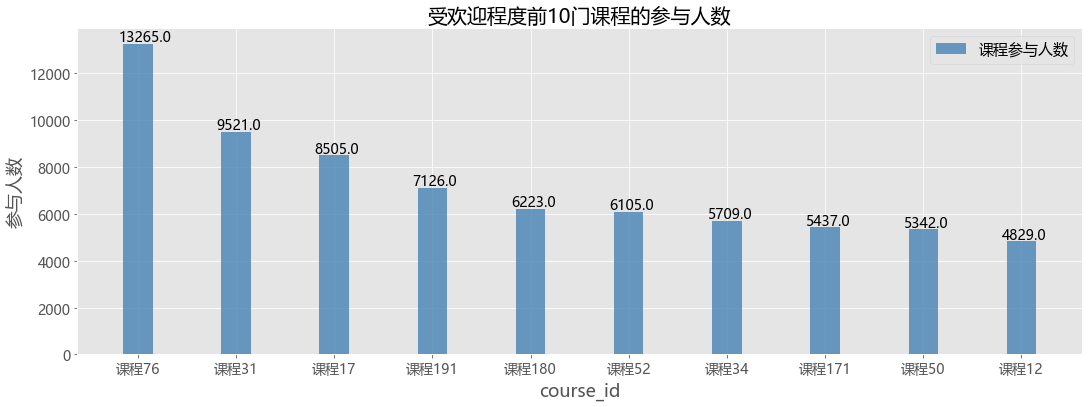

In [119]:
# 绘制最受欢迎前10的课程参与人数图
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')  # 设置图形的显示风格
fig = plt.figure(figsize=(18, 6))
# plt.subplot(2,2,1)
# 数据
sale = welcome['参与人数'].head(10).values
# nosale = [a_women_avg,b_women_avg,c_women_avg]
labels = welcome.head(10).index
bar_width = 0.3

# 中文乱码的处理
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# 绘图
plt.bar(np.arange(10), sale, label='课程参与人数', color='steelblue', alpha=0.8, width=bar_width)
# plt.bar(np.arange(3)+bar_width, nosale, label ='女', color = 'indianred', alpha = 0.8, width = bar_width)
# 添加轴标签
plt.xlabel('course_id', fontsize=18)
plt.ylabel('参与人数', fontsize=18)
# 添加标题
plt.title('受欢迎程度前10门课程的参与人数', fontsize=20)
# 添加刻度标签
plt.xticks(np.arange(10), labels, fontsize=14)
plt.yticks(fontsize=14)
# 设置Y轴的刻度范围
# plt.ylim([2500, 19000])

# 为每个条形图添加数值标签
for xsale, ysale in enumerate(sale):
    plt.text(xsale - 0.2, ysale + 100, '%.1f' % ysale, fontsize=14)

# for xnosale,ynosale in enumerate(nosale):
#     plt.text(xnosale+0.15, ynosale+30, '%.1f' %ynosale,fontsize = 10)

# 显示图例
plt.legend(loc='Top', fontsize=15)

In [120]:
# 选用study_information.csv中的用户 id和课程 id进行建模
user_course = data2[['user_id','course_id']]
user_course.head()

,user_id,course_id
0,用户3,课程106
1,用户3,课程136
2,用户3,课程205
3,用户4,课程26
4,用户4,课程34


In [121]:
# 构建用户物品矩阵
user_list = set(user_course['user_id'].values)
course_list = set(user_course['course_id'].values)

ui_matrix = pd.DataFrame(0,index=user_list, columns=course_list)
for i in user_course.index:
    ui_matrix.loc[user_course.loc[i,'user_id'],user_course.loc[i,'course_id']] = 1

In [122]:
# 求出物品相似度矩阵
item_matrix = pd.DataFrame(0,index=course_list, columns=course_list)
for i in item_matrix.index:
    for j in item_matrix.index:
        a = sum(ui_matrix.loc[:,[i,j]].sum(axis=1)==2)
        b = sum(ui_matrix.loc[:,[i,j]].sum(axis=1)!=0)
        item_matrix.loc[i,j] = a/b

In [123]:
# 将物品相似度矩阵对角线处理为零
for i in item_matrix.index:
    item_matrix.loc[i,i]=0

In [124]:
# 选出 总学习进度最高的 5 名用户
data2.sort_values(by=['learn_process'], ascending=False, inplace=True, na_position='first')

student_f5 = data2.head(5)[['user_id','course_id']]
data2.head()

,user_id,course_id,course_join_time,learn_process,price
26522,用户9192,课程21,2019-09-09 09:51:58,width: 99%;,169.000
37396,用户14966,课程21,2019-09-09 09:52:02,width: 99%;,169.000
105572,用户30820,课程136,2020-03-02 13:36:37,width: 99%;,0.000
37444,用户14989,课程21,2019-09-09 09:52:06,width: 99%;,169.000
35742,用户13869,课程21,2019-08-05 15:53:28,width: 99%;,169.000


In [125]:
# 测试集 用户物品矩阵
user_list_test = set(student_f5['user_id'].values)
course_list_test = set(student_f5['course_id'].values)

ui_matrix_test = pd.DataFrame(0,index=user_list_test, columns=course_list_test)
for i in student_f5.index:
    ui_matrix_test.loc[student_f5.loc[i,'user_id'],student_f5.loc[i,'course_id']] = 1

In [126]:
ui_matrix_test

,课程136,课程21
用户30820,1,0
用户14989,0,1
用户13869,0,1
用户14966,0,1
用户9192,0,1


In [127]:
# 推荐 3 门课程
res = pd.DataFrame('NaN', index=student_f5.index, columns=['用户 id','已选课程','推荐课程','T/F'])
res.loc[:,'用户 id'] = list(student_f5.iloc[:,0])
res.loc[:,'已选课程'] = list(student_f5.iloc[:,1])
res

,用户 id,已选课程,推荐课程,T/F
26522,用户9192,课程21,NaN,NaN
37396,用户14966,课程21,NaN,NaN
105572,用户30820,课程136,NaN,NaN
37444,用户14989,课程21,NaN,NaN
35742,用户13869,课程21,NaN,NaN


In [128]:
# 开始推荐
for i in res.index:
    if res.loc[i,'已选课程'] in list(item_matrix.index):
        res.loc[i,'推荐课程'] = item_matrix.loc[res.loc[i,'已选课程'],:].argmax()
        if res.loc[i,'推荐课程'] in course_list_test:
            res.loc[i,'T/F']=ui_matrix.loc[res.loc[i,'用户 id'], res.loc[i,'推荐课程']]==1
        else:
            res.loc[i,'T/F'] = False
res

,用户 id,已选课程,推荐课程,T/F
26522,用户9192,课程21,60,False
37396,用户14966,课程21,60,False
105572,用户30820,课程136,50,False
37444,用户14989,课程21,60,False
35742,用户13869,课程21,60,False


# 线上管理决策建议
## 宣传方面
该线上平台的用户分布总体来说较为集中，且存在明显地区差异。因此针对不同地区的用户，我们需要采用不同的方式来进行处理。

用户数相对较为庞大的地区：

加大宣传力度，进一步打开市场，增加顾客黏性。
对于重点地区增加调查，探索该地区用户的特点和与其他地区的核心差异所在，为以后指定营销方案提供基础
用户数相对较小的地区：

不可盲目夸大范围， 投入资本。
通过获客成本、投入产生比等指标衡量宣传策略及资金分配。
尽量保证重点地区业务（日活、留存、收入等）稳定情况下，再考虑次要地区的投入。
## 活跃度方面
根据用户在不同时段、日期的活跃表现，进行有针对性的运营策略及服务策略
在高活跃时间段（8：00-11：00、14：00-17：00、20：00-21：00）加强系统维护，保证课程流畅度
在这些时段多植入相关课程广告以及相关课程销售活动，以此留住更多客户，提高课程的吸引力和销售额。
## 流失方面
（外修外力）监控用户状态、收集用户数据（消费金额、登录频次、登录间隔；课程数、课程完成度、在线时长等）
根据用户数据将未流失用户进行划分，且针对不同类型用户实施不同的维护策略：
忠诚用户——补贴优惠卷、vip课程套组、免费福利等
一般用户——精准营销（以用户自身属性、需求、喜好的信息，进行有针对的个性化推荐）
潜水用户——降低价格、精准营销等
（内修内力）提升平台服务、软件自身质量；加强平台课程质量、丰富课程种类等
优化软件交互、画面、视频稳定性、清晰度等
搭建个性化推荐
线上课程方面
## 课程角度

课程销售——组合（同类课程打包、进阶课程组合），并给与不同的折扣优惠
付费课程促进策略：免费试听、限时折扣等
用户角度
协同过滤
适当通过“热卖”，“限时”，“折扣”等标语，吸引不同消费心理的用户